# Predicting GC-like phenotype and Naive/Memory separation in B cells within the general manifold

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
from glob import iglob
import anndata
# need to do 'pip3 install bbknn==1.3.8' to avoid incompatibility errors
import bbknn
# requires 'pip install scrublet'
#import scrublet as scr
import os
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib as mpl
import scipy
import matplotlib.pyplot as plt
import pickle

In [2]:
np.random.seed(0)

In [3]:
%%bash

pip freeze

aiohttp==3.6.2
airr==1.3.1
alembic==1.3.0
anndata==0.7.5
annoy==1.16.2
async-generator==1.10
async-timeout==3.0.1
attrs==19.3.0
backcall==0.1.0
bbknn==1.3.6
bleach==3.1.0
blinker==1.4
CellPhoneDB==2.1.5
certifi==2019.9.11
certipy==0.1.3
cffi==1.13.2
chardet==3.0.4
click==6.7
conda==4.7.12
conda-package-handling==1.6.0
cryptography==2.8
cycler==0.10.0
Cython==0.29.14
decorator==4.4.1
defusedxml==0.6.0
entrypoints==0.3
fbpca==1.0
geosketch==0.3
get-version==2.1
h5py==2.10.0
idna==2.7
imageio==2.9.0
importlib-metadata==0.23
intervaltree==2.1.0
ipykernel==5.1.3
ipython==7.9.0
ipython-genutils==0.2.0
jedi==0.15.1
Jinja2==2.10.3
joblib==0.14.0
json5==0.8.5
jsonschema==3.1.1
jupyter-client==5.3.3
jupyter-core==4.5.0
jupyter-rsession-proxy==1.0b6
jupyter-server-proxy==1.2.0
jupyterhub==1.0.0
jupyterlab==1.2.1
jupyterlab-server==1.0.6
kiwisolver==1.1.0
legacy-api-wrap==1.2
leidenalg==0.7.0
llvmlite==0.30.0
loompy==3.0.6
louvain==0.6.1
Mako==1.1.0
MarkupSafe==1.1.1
matplotlib==3.3.4
mistune==0.8

In [4]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

-----
anndata     0.7.5
scanpy      1.6.0
sinfo       0.3.1
-----
PIL                 8.1.0
anndata             0.7.5
annoy               NA
attr                19.3.0
backcall            0.1.0
bbknn               NA
cffi                1.13.2
constants           NA
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.1
decorator           4.4.1
get_version         2.1
h5py                2.10.0
highs_wrapper       NA
igraph              0.7.1
importlib_metadata  0.23
ipykernel           5.1.3
ipython_genutils    0.2.0
jedi                0.15.1
joblib              0.14.0
kiwisolver          1.1.0
legacy_api_wrap     1.2
leidenalg           0.7.0
llvmlite            0.30.0
louvain             0.6.1
matplotlib          3.3.4
more_itertools      NA
mpl_toolkits        NA
natsort             6.2.0
numba               0.46.0
numexpr             2.7.0
numpy               1.17.4
packaging           19.2
pandas              0.25.3
parso               0.5.1
pexpect        

In [5]:
save_path = '/lustre/scratch117/cellgen/team292/aa22/adata_objects/202009_CVID_revision/'

## Reading the fully analysed transcriptomics dataset (all cells manifold)

In [6]:
# normalised, log tr and scaled values in .X, HVG-subsetted
# normalised and log tr in .raw.X, all genes
adata_hvg = sc.read(save_path+'adata_hvg_bbknn_by_sample_GEX_and_SoupX_denoised_protein_validation_cohort_20210212.h5ad')

In [7]:
# getting final annotation
#annot_table = pd.read_csv(save_path + 'annotation_of_adata_hvg_BBKNN_GEX_and_SoupX_denoised_protein_all_samples_20210108.csv',
#                         index_col=0)
#annot_table

In [8]:
#adata_hvg.obs['cell_type_final'] = annot_table.loc[adata_hvg.obs_names, 'cell_type_final']
#np.unique(adata_hvg.obs['cell_type_final'])

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 22 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:31)


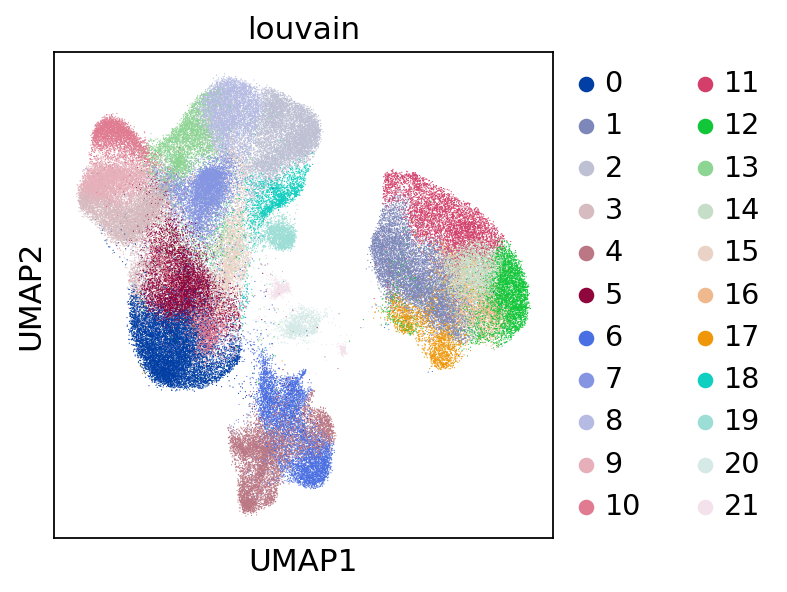

CPU times: user 32.7 s, sys: 1.16 s, total: 33.9 s
Wall time: 33.8 s


In [12]:
%%time
sc.tl.louvain(adata_hvg, resolution=2.0)
sc.pl.umap(adata_hvg, color='louvain')

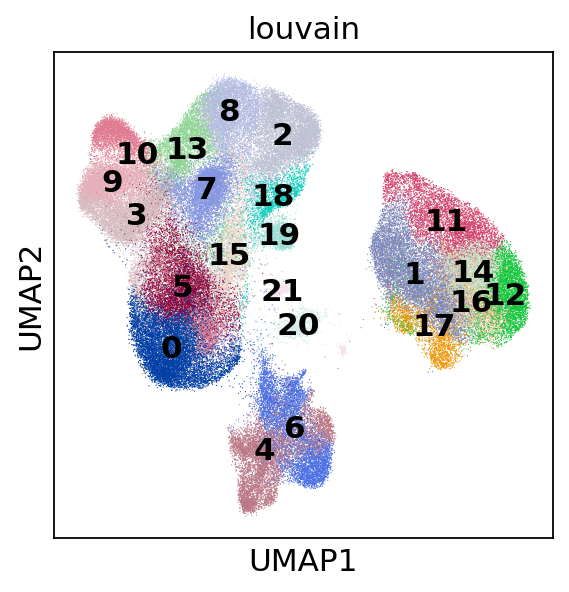

In [13]:
sc.pl.umap(adata_hvg, color='louvain', legend_loc='on data')

In [ ]:
# B cells: clusters 4 and 6

# 1. Predicting GC-like phenotype from the Milpied et. al. dataset

In [9]:
adata_GC_hvg = sc.read('/lustre/scratch117/cellgen/team292/aa22/adata_objects/CVID/202003_first_submission/adata_Milpied_GC_processed.h5ad')

/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [10]:
# using all genes
adata_GC_hvg_full = anndata.AnnData(X = adata_GC_hvg.raw.X,
                              obs = adata_GC_hvg.obs,
                              var = adata_GC_hvg.raw.var,
                              obsm = adata_GC_hvg.obsm,
                              varm = adata_GC_hvg.raw.varm)
# scaling
sc.pp.scale(adata_GC_hvg_full, max_value=10)

In [14]:
adata_hvg_B_cells = adata_hvg[adata_hvg.obs['louvain'].isin(['4','6'])].copy()

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [15]:
adata_B_full = anndata.AnnData(X = adata_hvg_B_cells.raw.X,
                              obs = adata_hvg_B_cells.obs,
                              var = adata_hvg_B_cells.raw.var,
                              obsm = adata_hvg_B_cells.obsm,
                              varm = adata_hvg_B_cells.raw.varm)

# scaling
sc.pp.scale(adata_B_full, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


# Annotation - through GC B-cell data from [Milpied et al., Nature Immunology, 2018](https://www.nature.com/articles/s41590-018-0181-4#rightslink)

In [16]:
# full (all genes) versions of the annotated object and test object
# here both the datasets are normalised, log transformed and scaled
adata_train = adata_GC_hvg_full.copy()

adata_test = adata_B_full.copy()

In [17]:
adata_test

AnnData object with n_obs × n_vars = 13089 × 21749
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'genome-8', 'n_cells-8', 'mean', 'std'
    obsm: 'X_pca', 'X_umap'

### Subsetting both datasets' copies to common genes only

I will train logreg on the subsetted data and tranfer the annotation onto the corresponding subsetted new data and then transfer that onto the full (with all genes) new dataset

In [18]:
# list of genes shared between blood and bone marrow data
# doing sorted on the overall list is VERY important for consistent ordering of the genes
common_genes = sorted(list(set(adata_train.var_names) & set(adata_test.var_names)))
print(len(common_genes),"genes are shared between previous training and test data \n",
      len(set(adata_train.var_names)), 'genes in training data \n',
      len((set(adata_test.var_names))), 'genes in test joint data \n')

13702 genes are shared between previous training and test data 
 14157 genes in training data 
 21749 genes in test joint data 



In [19]:
adata_train.var_names

Index(['FO538757.2', 'AP006222.2', 'RP11-206L10.9', 'LINC00115', 'FAM41C',
       'RP11-54O7.1', 'NOC2L', 'RP11-54O7.17', 'HES4', 'ISG15',
       ...
       'MT-ND4', 'MT-ND5', 'MT-ND6', 'MT-CYB', 'BX004987.4', 'AC145212.2',
       'AL592183.1', 'AL354822.1', 'AC004556.1', 'AC240274.1'],
      dtype='object', name='index', length=14157)

Going to copy a joint dataset with only common genes, but then transfer annotation from logreg onto the full dataset

In [20]:
adata_train_copy = adata_train[:,common_genes]

In [21]:
adata_train_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M-AS1', 'A2ML1', 'A4GALT', 'AAAS', 'AACS',
       'AAED1', 'AAGAB', 'AAK1',
       ...
       'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1',
       'ZZZ3', 'bP-21264C1.2'],
      dtype='object', name='index', length=13702)

In [22]:
adata_test_copy = adata_test[:,common_genes]
adata_test_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M-AS1', 'A2ML1', 'A4GALT', 'AAAS', 'AACS',
       'AAED1', 'AAGAB', 'AAK1',
       ...
       'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1',
       'ZZZ3', 'bP-21264C1.2'],
      dtype='object', name='index', length=13702)

In [23]:
# checking gene correspondence!
list(adata_test_copy.var_names) == list(adata_train_copy.var_names)

True

In [24]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 859 × 13702
    obs: 'cell_id', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'louvain', 'cell_type'
    var: 'n_cells', 'mean', 'std'
    obsm: 'X_pca', 'X_umap'

In [25]:
np.unique(adata_train_copy.obs['cell_type'],return_counts=True)

(array(['GC_B_cells', 'Other_B_cells'], dtype=object), array([358, 501]))

# Training a logistic regression model on previously annotated SS2 data

In [26]:
adata_train_copy.obs['cell_type'].head()

index
0    Other_B_cells
1       GC_B_cells
2    Other_B_cells
3    Other_B_cells
4    Other_B_cells
Name: cell_type, dtype: category
Categories (2, object): ['GC_B_cells', 'Other_B_cells']

In [27]:
celltypes_train = adata_train_copy.obs['cell_type']

In [28]:
adata_train_copy.X.shape

(859, 13702)

Using ONLY COMMON GENES

In [29]:
%%time
# training a logistic regression model
logisticRegr = LogisticRegression(max_iter = 10000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr.fit(adata_train_copy.X, celltypes_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CPU times: user 8.43 s, sys: 20.5 s, total: 29 s
Wall time: 3.08 s


LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [30]:
# already done
# Saving model based on all genes
pkl_filename = "logreg_GC_all_genes_20210215.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(logisticRegr, file)

In [31]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 859 × 13702
    obs: 'cell_id', 'n_counts', 'log_counts', 'n_genes', 'percent_mito', 'louvain', 'cell_type'
    var: 'n_cells', 'mean', 'std'
    obsm: 'X_pca', 'X_umap'

In [32]:
adata_test_copy

View of AnnData object with n_obs × n_vars = 13089 × 13702
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'genome-8', 'n_cells-8', 'mean', 'std'
    obsm: 'X_pca', 'X_umap'

In [33]:
logisticRegr

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [34]:
%%time
predictions = logisticRegr.predict(adata_test_copy.X)
adata_test_copy.obs['GC_celltype_predictions_all_genes'] = predictions

Trying to set attribute `.obs` of view, copying.


CPU times: user 11.4 s, sys: 7.66 s, total: 19 s
Wall time: 17.6 s


In [35]:
%%time
# probabilities
probabilities = logisticRegr.predict_proba(adata_test_copy.X)
probs_adata = []
for i,clus in enumerate(adata_test_copy.obs['GC_celltype_predictions_all_genes']):
    probs_adata.append(probabilities[i,logisticRegr.classes_==clus][0])


CPU times: user 916 ms, sys: 1.47 s, total: 2.39 s
Wall time: 697 ms


In [36]:
# need to only assign predictions and probabilities to B cell clusters
list(adata_test_copy.obs.index) == list(adata_hvg.obs.index)

False

In [37]:
adata_test_copy.obs['probabilities_GC_all_genes'] = probs_adata

In [38]:
def add_predictions_and_probs(barcode, 
                              col # either GC_celltype_predictions_all_genes or probabilities_GC_all_genes
                             ):
    
    barcode_is_B_cell = barcode in adata_test_copy.obs_names
    
    if barcode_is_B_cell:
        value = adata_test_copy.obs.loc[barcode, col]
        return(value)
    else:
        if col == 'probabilities_GC_all_genes':
            return(0)
        elif col == 'GC_celltype_predictions_all_genes':
            return('NA')
        

In [39]:
adata_hvg.obs['barcode'] = adata_hvg.obs.index

In [40]:
for column in ['GC_celltype_predictions_all_genes','probabilities_GC_all_genes']:
    print(column)
    adata_hvg.obs[column] = adata_hvg.obs['barcode'].apply(lambda x: add_predictions_and_probs(x, column))

GC_celltype_predictions_all_genes
probabilities_GC_all_genes


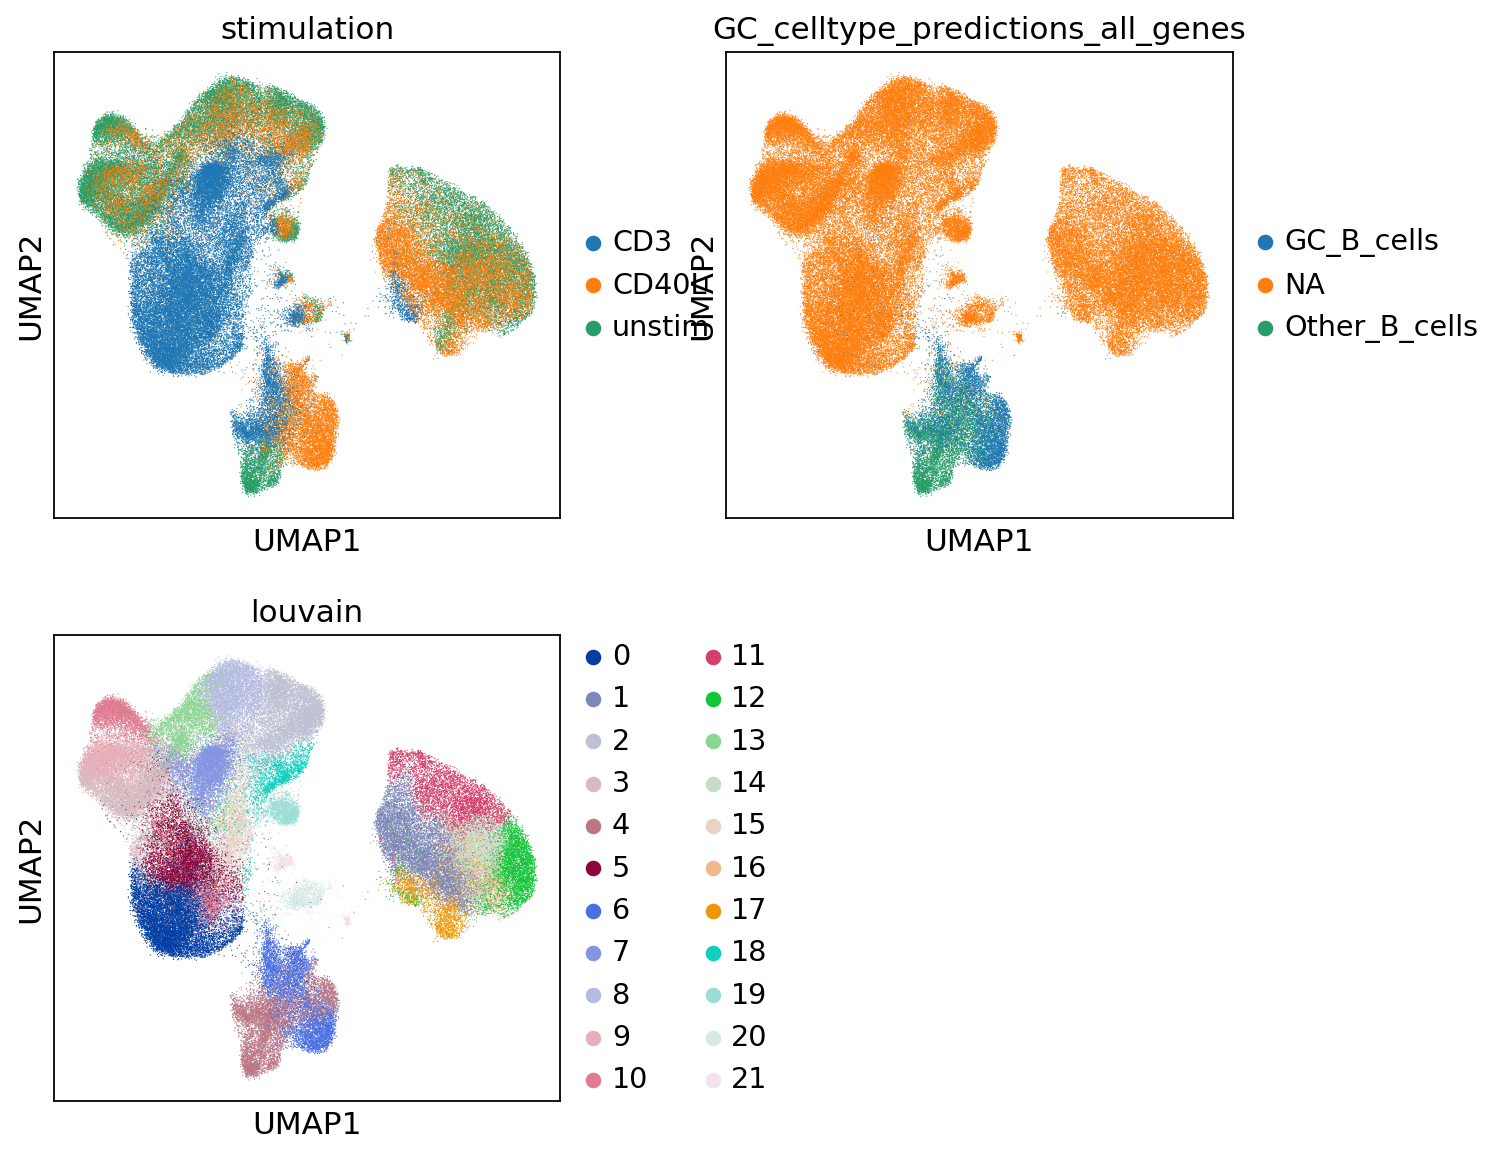

In [44]:
sc.pl.umap(adata_hvg, color = [#'probabilities_GC_hvgs', 'GC_celltype_predictions_hvgs',
                               #'probabilities_GC_all_genes', 
                                'stimulation',
                              'GC_celltype_predictions_all_genes', 'louvain'],
           ncols=2,
           cmap='OrRd')

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


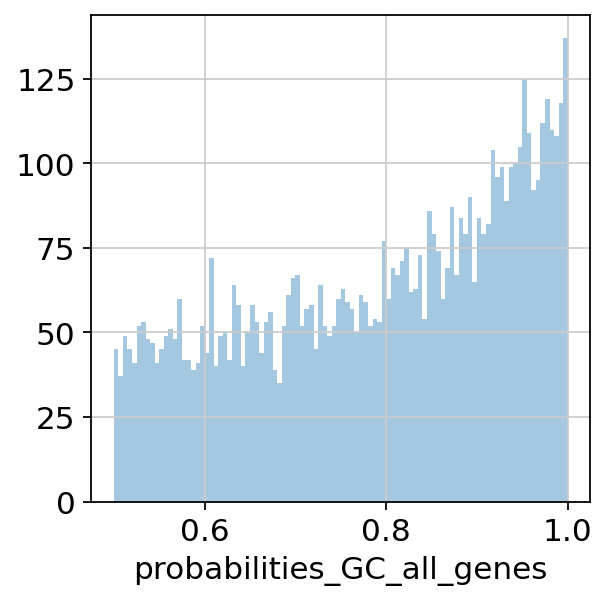

In [45]:
p3 = sns.distplot(adata_hvg[adata_hvg.obs['GC_celltype_predictions_all_genes'] == 'GC_B_cells'].obs['probabilities_GC_all_genes'], 
                  bins=100, kde=False)
plt.show()

In [46]:
np.median(adata_hvg[adata_hvg.obs['GC_celltype_predictions_all_genes'] == 'GC_B_cells'].obs['probabilities_GC_all_genes'])

0.8154266230762828

In [47]:
table_predictions = adata_hvg.obs.loc[:, ['GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes']]

In [48]:
table_predictions.head()

GC_celltype_predictions_all_genes  \
index                                                  
AAACCTGAGAATGTGT-1                                NA   
AAACCTGAGACTAAGT-1                                NA   
AAACCTGAGCCGCCTA-1                                NA   
AAACCTGAGCGCCTCA-1                                NA   
AAACCTGAGGATGTAT-1                                NA   

                    probabilities_GC_all_genes  
index                                           
AAACCTGAGAATGTGT-1                         0.0  
AAACCTGAGACTAAGT-1                         0.0  
AAACCTGAGCCGCCTA-1                         0.0  
AAACCTGAGCGCCTCA-1                         0.0  
AAACCTGAGGATGTAT-1                         0.0

In [49]:
table_predictions.shape

(107050, 2)

In [50]:
table_predictions.to_csv(save_path + 'table_predictions_GC_B_cells_GEX_and_SoupX_denoised_protein_validation_cohort_20210215.csv')

In [8]:
table_predictions_GC = pd.read_csv(save_path + 'table_predictions_GC_B_cells_GEX_and_SoupX_denoised_protein_validation_cohort_20210215.csv', index_col=0)

In [9]:
adata_hvg.obs['GC_celltype_predictions_all_genes'] = table_predictions_GC.loc[adata_hvg.obs_names, 'GC_celltype_predictions_all_genes']
adata_hvg.obs['probabilities_GC_all_genes'] = table_predictions_GC.loc[adata_hvg.obs_names, 'probabilities_GC_all_genes']

... storing 'GC_celltype_predictions_all_genes' as categorical


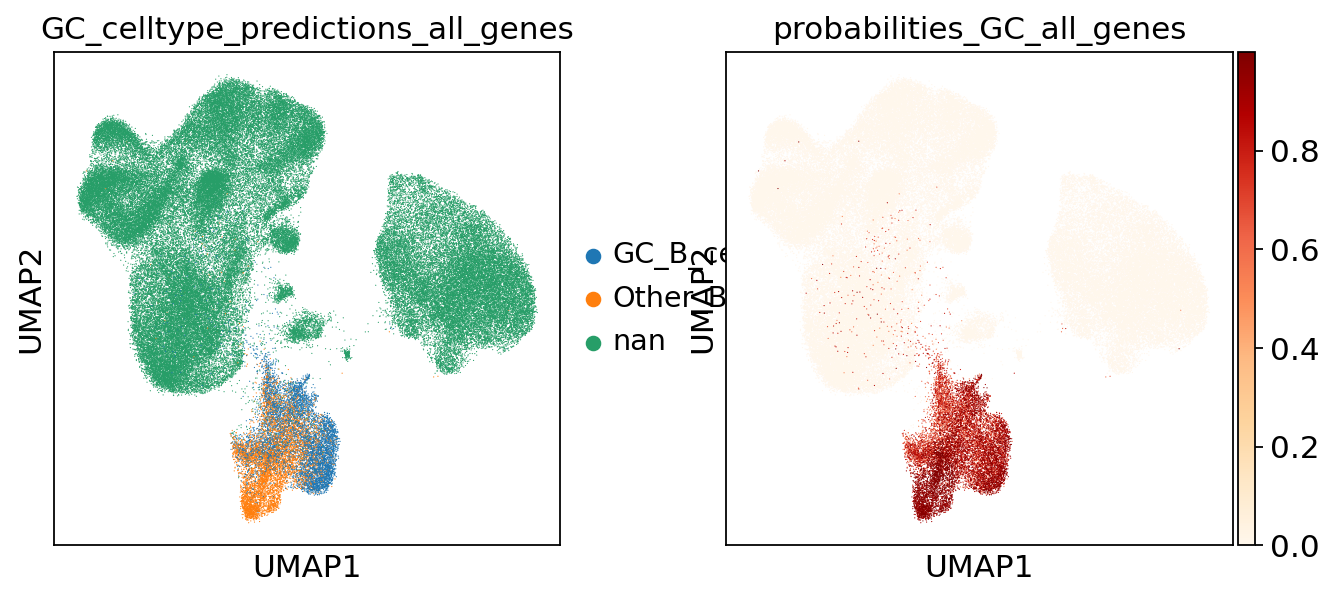

In [10]:
sc.pl.umap(adata_hvg, color = ['GC_celltype_predictions_all_genes',
                              'probabilities_GC_all_genes'], cmap='OrRd')

# 2. Predicting Naive/Memory B cells from (a) old SS2 data

In [51]:
adata_SS2_hvg = sc.read('/home/jovyan/notebooks/Vento_Lab/CVID/GitHub_to_post/CVID_old_full/scTranscriptomics/adata_SS2_corrected.h5ad')

/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/anndata/compat/__init__.py:182: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [52]:
adata_SS2_hvg

AnnData object with n_obs × n_vars = 1324 × 6228
    obs: 'batch', 'batchcode', 'bh_pval', 'celltype', 'lane', 'n_counts', 'n_genes', 'percent_mito', 'scrublet_cluster_score', 'scrublet_score', 'treatment', 'is_doublet', 'louvain', 'is_doublet_poptrim', 'cell_id'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

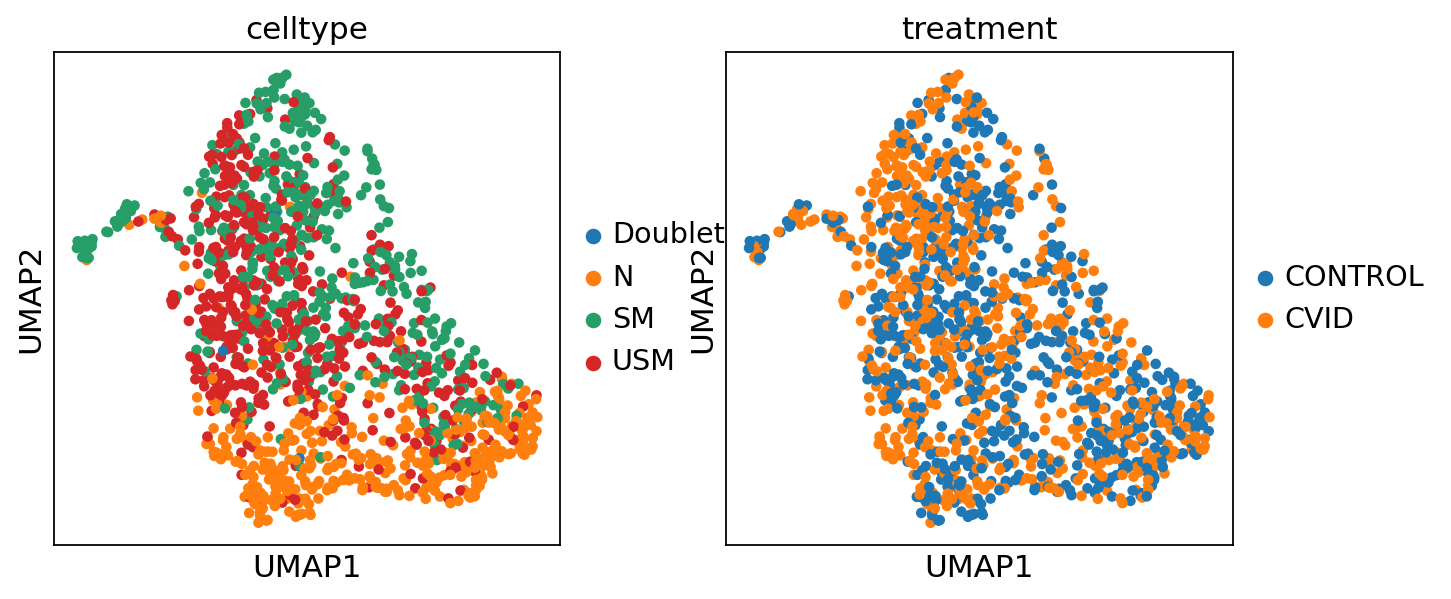

In [53]:
sc.pl.umap(adata_SS2_hvg, color=['celltype','treatment'])

In [54]:
# if using all genes
adata_SS2_hvg_full = anndata.AnnData(X = adata_SS2_hvg.raw.X,
                              obs = adata_SS2_hvg.obs,
                              var = adata_SS2_hvg.raw.var,
                              obsm = adata_SS2_hvg.obsm,
                              varm = adata_SS2_hvg.raw.varm)
# scaling
sc.pp.scale(adata_SS2_hvg_full, max_value=10)

In [55]:
adata_hvg_B_cells = adata_hvg[adata_hvg.obs['louvain'].isin(['4', '6'])].copy()

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [56]:
adata_B_full = anndata.AnnData(X = adata_hvg_B_cells.raw.X,
                              obs = adata_hvg_B_cells.obs,
                              var = adata_hvg_B_cells.raw.var,
                              obsm = adata_hvg_B_cells.obsm,
                              varm = adata_hvg_B_cells.raw.varm)

# scaling
sc.pp.scale(adata_B_full, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [57]:
# full (all genes) versions of the annotated object and test object
# here both the datasets are normalised, log transformed and scaled
adata_train = adata_SS2_hvg_full.copy()

adata_test = adata_B_full.copy()

In [58]:
adata_test

AnnData object with n_obs × n_vars = 13089 × 21749
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'genome-8', 'n_cells-8

### Subsetting both datasets' copies to common genes only

I will train logreg on the subsetted data and tranfer the annotation onto the corresponding subsetted new data and then transfer that onto the full (with all genes) new dataset

In [59]:
# list of genes shared between blood and bone marrow data
# doing sorted on the overall list is VERY important for consistent ordering of the genes
common_genes = sorted(list(set(adata_train.var_names) & set(adata_test.var_names)))
print(len(common_genes),"genes are shared between previous training and test data \n",
      len(set(adata_train.var_names)), 'genes in training data \n',
      len((set(adata_test.var_names))), 'genes in test joint data \n')

17441 genes are shared between previous training and test data 
 21030 genes in training data 
 21749 genes in test joint data 



In [60]:
adata_train.var_names

Index(['TSPAN6', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2', 'GCLC',
       'NFYA', 'STPG1',
       ...
       'RP11-108M9.2', 'RP11-116D17.3', 'IL12B', 'ATP11A-AS1', 'REEP1',
       'RP11-191L9.4', 'ZNF695', 'C16orf47', 'CYSLTR2', 'POU5F1B'],
      dtype='object', name='index', length=21030)

Going to copy a joint dataset with only common genes, but then transfer annotation from logreg onto the full dataset

In [61]:
adata_train_copy = adata_train[:,common_genes]

In [62]:
adata_train_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAAS', 'AACS',
       'AAED1', 'AAGAB',
       ...
       'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1', 'ZZZ3',
       'bP-21264C1.2', 'bP-2189O9.3'],
      dtype='object', name='index', length=17441)

In [63]:
adata_test_copy = adata_test[:,common_genes]
adata_test_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2ML1', 'A4GALT', 'A4GNT', 'AAAS', 'AACS',
       'AAED1', 'AAGAB',
       ...
       'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1', 'ZZZ3',
       'bP-21264C1.2', 'bP-2189O9.3'],
      dtype='object', name='index', length=17441)

In [64]:
# checking gene correspondence!
list(adata_test_copy.var_names) == list(adata_train_copy.var_names)

True

In [65]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 1324 × 17441
    obs: 'batch', 'batchcode', 'bh_pval', 'celltype', 'lane', 'n_counts', 'n_genes', 'percent_mito', 'scrublet_cluster_score', 'scrublet_score', 'treatment', 'is_doublet', 'louvain', 'is_doublet_poptrim', 'cell_id'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'mean', 'std'
    obsm: 'X_pca', 'X_umap'

In [66]:
np.unique(adata_train_copy.obs['celltype'],return_counts=True)

(array(['Doublets', 'N', 'SM', 'USM'], dtype=object),
 array([  4, 377, 450, 493]))

# Training a logistic regression model on previously annotated SS2 data

In [67]:
adata_train_copy.obs['celltype'].head()

index
SCGC--2500_C02    N
SCGC--2499_C03    N
SCGC--2500_C03    N
SCGC--2499_C04    N
SCGC--2500_C04    N
Name: celltype, dtype: category
Categories (4, object): ['Doublets', 'N', 'SM', 'USM']

In [68]:
celltypes_train = adata_train_copy.obs['celltype']

In [69]:
adata_train_copy.X.shape

(1324, 17441)

Using ONLY COMMON GENES

In [70]:
%%time
# training a logistic regression model
logisticRegr = LogisticRegression(max_iter = 10000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr.fit(adata_train_copy.X, celltypes_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CPU times: user 3min 8s, sys: 7min 15s, total: 10min 23s
Wall time: 41.6 s


LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [71]:
# already done
# Saving model based on all genes
pkl_filename = "logreg_from_SS2_all_genes_20210215.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(logisticRegr, file)

In [72]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 1324 × 17441
    obs: 'batch', 'batchcode', 'bh_pval', 'celltype', 'lane', 'n_counts', 'n_genes', 'percent_mito', 'scrublet_cluster_score', 'scrublet_score', 'treatment', 'is_doublet', 'louvain', 'is_doublet_poptrim', 'cell_id'
    var: 'n_cells-0', 'n_cells-1', 'n_cells-2', 'n_cells-3', 'mean', 'std'
    obsm: 'X_pca', 'X_umap'

In [73]:
adata_test_copy

View of AnnData object with n_obs × n_vars = 13089 × 17441
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', 'genome-7', 'n_cells-7', 'gene_ids-8', 'feature_types-8', 'genome-8', 'n

In [74]:
logisticRegr

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [75]:
%%time
predictions = logisticRegr.predict(adata_test_copy.X)
adata_test_copy.obs['celltype_predictions_all_genes_from_SS2'] = predictions

Trying to set attribute `.obs` of view, copying.


CPU times: user 16.1 s, sys: 10.7 s, total: 26.8 s
Wall time: 24.3 s


In [76]:
%%time
# probabilities
probabilities = logisticRegr.predict_proba(adata_test_copy.X)
probs_adata = []
for i,clus in enumerate(adata_test_copy.obs['celltype_predictions_all_genes_from_SS2']):
    probs_adata.append(probabilities[i,logisticRegr.classes_==clus][0])


CPU times: user 1.46 s, sys: 1.63 s, total: 3.09 s
Wall time: 835 ms


In [77]:
# need to only assign predictions and probabilities to B cell clusters
list(adata_test_copy.obs.index) == list(adata_hvg.obs.index)

False

In [78]:
adata_test_copy.obs['probabilities_from_SS2_all_genes'] = probs_adata

In [79]:
def add_predictions_and_probs(barcode, 
                              col # either celltype_predictions_all_genes_from_SS2 or probabilities_from_SS2_all_genes
                             ):
    
    barcode_is_B_cell = barcode in adata_test_copy.obs_names
    
    if barcode_is_B_cell:
        value = adata_test_copy.obs.loc[barcode, col]
        return(value)
    else:
        if col == 'probabilities_from_SS2_all_genes':
            return(0)
        elif col == 'celltype_predictions_all_genes_from_SS2':
            return('NA')
        

In [80]:
adata_hvg.obs['barcode'] = adata_hvg.obs.index

In [81]:
for column in ['celltype_predictions_all_genes_from_SS2','probabilities_from_SS2_all_genes']:
    print(column)
    adata_hvg.obs[column] = adata_hvg.obs['barcode'].apply(lambda x: add_predictions_and_probs(x, column))

celltype_predictions_all_genes_from_SS2
probabilities_from_SS2_all_genes


... storing 'celltype_predictions_all_genes_from_SS2' as categorical


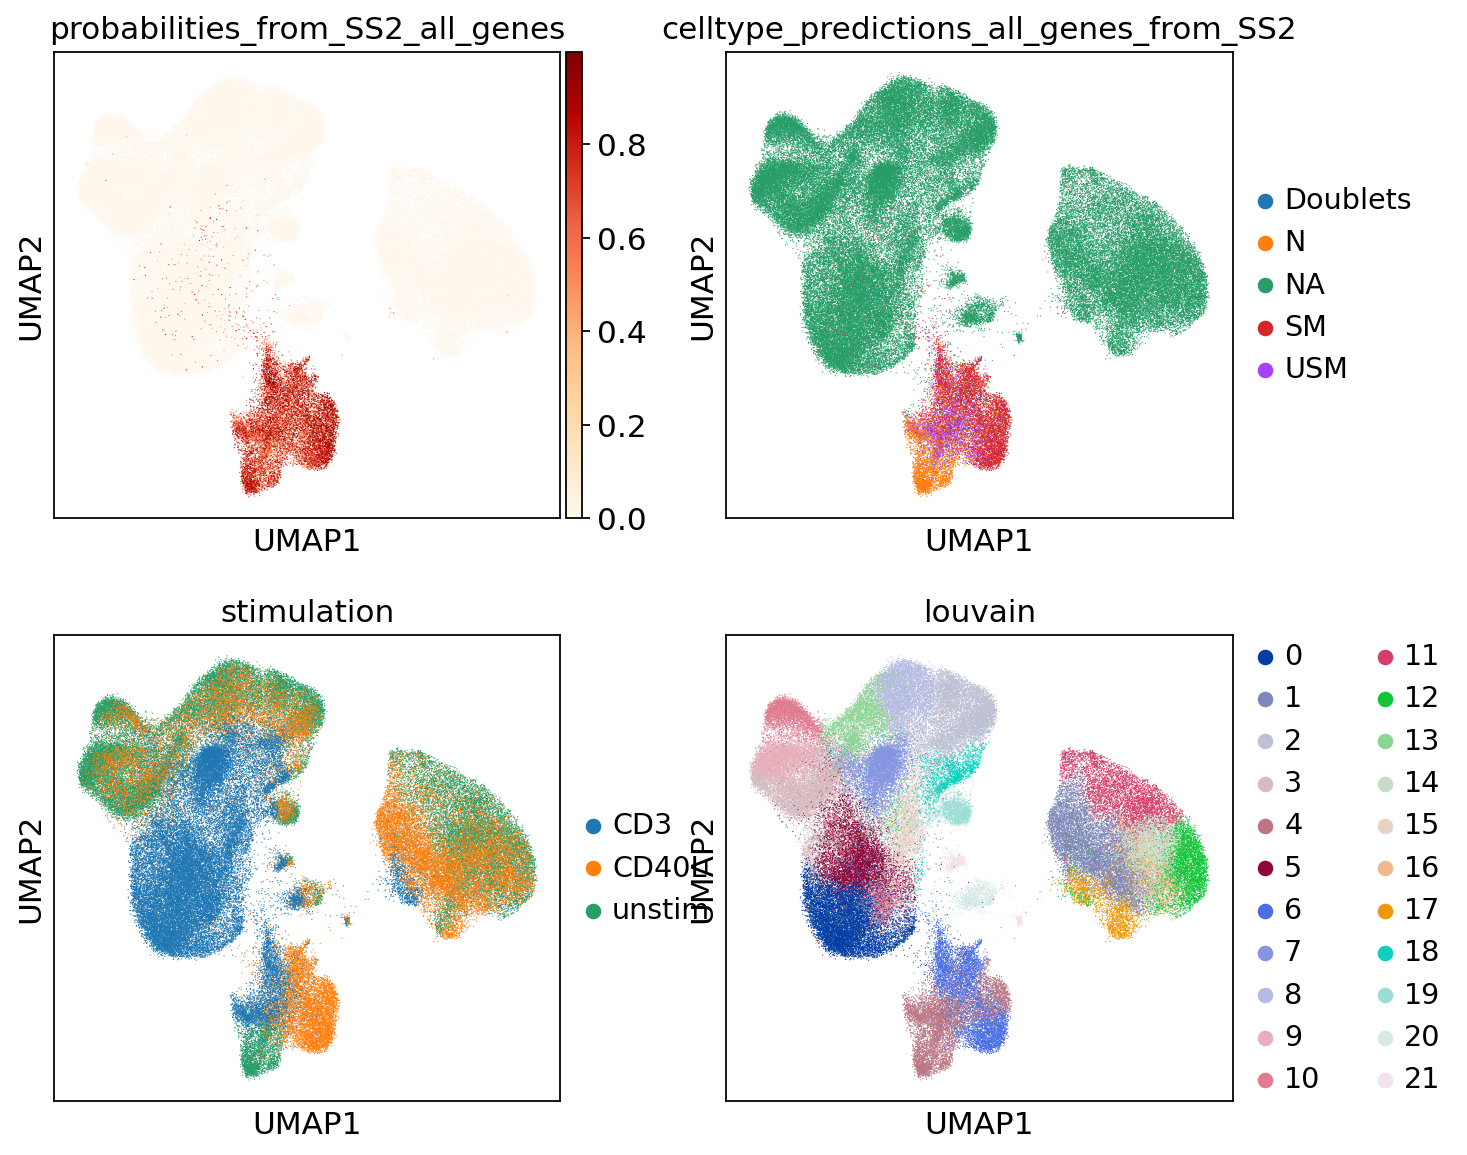

In [82]:
sc.pl.umap(adata_hvg, color = [#'probabilities_GC_hvgs', 'GC_celltype_predictions_hvgs',
                               'probabilities_from_SS2_all_genes', 'celltype_predictions_all_genes_from_SS2',
                              'stimulation', 'louvain'],
           ncols=2,
           cmap='OrRd')

In [83]:
table_predictions_from_SS2 = adata_hvg.obs.loc[:, ['celltype_predictions_all_genes_from_SS2', 'probabilities_from_SS2_all_genes']]

In [84]:
table_predictions_from_SS2.head()

celltype_predictions_all_genes_from_SS2  \
index                                                        
AAACCTGAGAATGTGT-1                                      NA   
AAACCTGAGACTAAGT-1                                      NA   
AAACCTGAGCCGCCTA-1                                      NA   
AAACCTGAGCGCCTCA-1                                      NA   
AAACCTGAGGATGTAT-1                                      NA   

                    probabilities_from_SS2_all_genes  
index                                                 
AAACCTGAGAATGTGT-1                               0.0  
AAACCTGAGACTAAGT-1                               0.0  
AAACCTGAGCCGCCTA-1                               0.0  
AAACCTGAGCGCCTCA-1                               0.0  
AAACCTGAGGATGTAT-1                               0.0

In [85]:
table_predictions_from_SS2.shape

(107050, 2)

In [86]:
table_predictions_from_SS2.to_csv(save_path + 'table_predictions_N_USM_SM_B_cells_from_SS2_GEX_and_SoupX_denoised_protein_validation_cohort_20210215.csv')

# 4. Predicting Naive/Memory B cells from (c) Hamish King's [paper](https://www.biorxiv.org/content/10.1101/2020.04.28.054775v2.full.pdf)

In [87]:
# raw GEX counts - takes a while to read
Hamish_X = pd.read_csv('/lustre/scratch117/cellgen/team292/aa22/Hamish_B_cells/SEURAT_OBJECTS/Hamish_all_cells_raw_counts.csv', sep='\t',
                      index_col=0)
# to get cells x genes matrix
Hamish_X = Hamish_X.T

# metadata with annotation in 'CellType'
Hamish_meta = pd.read_csv('/lustre/scratch117/cellgen/team292/aa22/Hamish_B_cells/SEURAT_OBJECTS/Hamish_all_cells_raw_counts_metadata.csv',
                         sep='\t', index_col=0)

In [88]:
Hamish_X

AL627309.1  AL669831.5  LINC00115  FAM41C  NOC2L  \
BCP3_MBC_AAAGTAGGTACATCCA           0           0          0       0      1   
BCP3_MBC_AACACGTCAGGGCATA           0           0          0       0      0   
BCP3_MBC_AATCCAGCAGTCTTCC           0           0          0       0      0   
BCP3_MBC_ACACTGAAGTGAAGAG           0           0          0       0      0   
BCP3_MBC_ACGCCGACACTGCCAG           0           0          0       0      1   
...                               ...         ...        ...     ...    ...   
BCP9_MBC_TTTGTCAGTGCAACGA           0           0          0       0      0   
BCP9_MBC_TTTGTCATCAGTTGAC           0           0          0       0      0   
BCP9_MBC_TTTGTCATCATAAAGG           0           0          0       0      2   
BCP9_MBC_TTTGTCATCGCAAGCC           0           0          0       0      0   
BCP9_MBC_TTTGTCATCTTCGGTC           0           0          0       0      0   

                           KLHL17  HES4  ISG15  AGRN  C1orf159  ...  \
BCP3_MBC_AAAGTAGGTACATCCA       0     0      0     0         0  ...   
BCP3_MBC_AACACGTCAGGGCATA       0     0      0     0         0  ...   
BCP3_MBC_AATCCAGCAGTCTTCC       0     1      1     0         0  ...   
BCP3_MBC_ACACTGAAGTGAAGAG       0     0      0     0         0  ...   
BCP3_MBC_ACGCCGACACTGCCAG       0     0      2     0         0  ...   
...                           ...   ...    ...   ...       ...  ...   
BCP9_MBC_TTTGTCAGTGCAACGA       0     0      0     0         0  ...   
BCP9_MBC_TTTGTCATCAGTTGAC       0     0      0     0         0  ...   
BCP9_MBC_TTTGTCATCATAAAGG       0     0      1     0         0  ...   
BCP9_MBC_TTTGTCATCGCAAGCC       0     0      0     0         0  ...   
BCP9_MBC_TTTGTCATCTTCGGTC       0     0      0     0         0  ...   

                           AC006486.1  AC005392.2  NUCB1-AS1  LRRC4B  KIR2DL1  \
BCP3_MBC_AAAGTAGGTACATCCA           0           0          0       0        0   
BCP3_MBC_AACACGTCAGGGCATA           0           0          0       0        0   
BCP3_MBC_AATCCAGCAGTCTTCC           0           0          0       0        0   
BCP3_MBC_ACACTGAAGTGAAGAG           0           0          0       0        0   
BCP3_MBC_ACGCCGACACTGCCAG           0           0          0       0        0   
...                               ...         ...        ...     ...      ...   
BCP9_MBC_TTTGTCAGTGCAACGA           0           0          0       0        0   
BCP9_MBC_TTTGTCATCAGTTGAC           0           0          0       0        0   
BCP9_MBC_TTTGTCATCATAAAGG           0           0          0       0        0   
BCP9_MBC_TTTGTCATCGCAAGCC           0           0          0       0        0   
BCP9_MBC_TTTGTCATCTTCGGTC           0           0          0       0        0   

                           SLC7A4  MCHR1  AL031593.1  MOV10L1  AC007325.2  
BCP3_MBC_AAAGTAGGTACATCCA       0      0           0        0           0  
BCP3_MBC_AACACGTCAGGGCATA       0      0           0        0           0  
BCP3_MBC_AATCCAGCAGTCTTCC       0      0           0        0           0  
BCP3_MBC_ACACTGAAGTGAAGAG       0      0           0        0           0  
BCP3_MBC_ACGCCGACACTGCCAG       0      0           0        0           0  
...                           ...    ...         ...      ...         ...  
BCP9_MBC_TTTGTCAGTGCAACGA       0      0           0        0           0  
BCP9_MBC_TTTGTCATCAGTTGAC       0      0           0        0           0  
BCP9_MBC_TTTGTCATCATAAAGG       0      0           0        0           0  
BCP9_MBC_TTTGTCATCGCAAGCC       0      0           0        0           0  
BCP9_MBC_TTTGTCATCTTCGGTC       0      0           0        0           0  

[52766 rows x 20052 columns]

In [89]:
# is this raw values? looks like it
np.unique(Hamish_X.loc['BCP9_MBC_TTTGTCAGTGCAACGA'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 25, 26, 29, 30, 31, 32, 33, 35, 36, 37,
       38, 43, 44, 45, 59, 71, 73, 84, 90])

In [90]:
Hamish_meta

nCount_RNA  nFeature_RNA  percent.mito  \
BCP3_MBC_AAAGTAGGTACATCCA        3004          1374      0.069825   
BCP3_MBC_AACACGTCAGGGCATA        6808          1823      0.031561   
BCP3_MBC_AATCCAGCAGTCTTCC        7931          2668      0.048512   
BCP3_MBC_ACACTGAAGTGAAGAG        2942          1233      0.041626   
BCP3_MBC_ACGCCGACACTGCCAG        6670          2228      0.051384   
...                               ...           ...           ...   
BCP9_MBC_TTTGTCAGTGCAACGA        4054          1416      0.029447   
BCP9_MBC_TTTGTCATCAGTTGAC        7409          1955      0.054478   
BCP9_MBC_TTTGTCATCATAAAGG        6863          1979      0.055319   
BCP9_MBC_TTTGTCATCGCAAGCC        3386          1290      0.054982   
BCP9_MBC_TTTGTCATCTTCGGTC        9183          2464      0.044528   

                           percent.ribo Donor    Sample Assay Status  \
BCP3_MBC_AAAGTAGGTACATCCA      0.240234  BCP3  BCP3_MBC    5P    OSA   
BCP3_MBC_AACACGTCAGGGCATA      0.430196  BCP3  BCP3_MBC    5P    OSA   
BCP3_MBC_AATCCAGCAGTCTTCC      0.264428  BCP3  BCP3_MBC    5P    OSA   
BCP3_MBC_ACACTGAAGTGAAGAG      0.312846  BCP3  BCP3_MBC    5P    OSA   
BCP3_MBC_ACGCCGACACTGCCAG      0.317530  BCP3  BCP3_MBC    5P    OSA   
...                                 ...   ...       ...   ...    ...   
BCP9_MBC_TTTGTCAGTGCAACGA      0.361025  BCP9  BCP9_MBC    5P     RT   
BCP9_MBC_TTTGTCATCAGTTGAC      0.353917  BCP9  BCP9_MBC    5P     RT   
BCP9_MBC_TTTGTCATCATAAAGG      0.372368  BCP9  BCP9_MBC    5P     RT   
BCP9_MBC_TTTGTCATCGCAAGCC      0.314541  BCP9  BCP9_MBC    5P     RT   
BCP9_MBC_TTTGTCATCTTCGGTC      0.410945  BCP9  BCP9_MBC    5P     RT   

                            S.Score  G2M.Score  ... IGL_C_Gene  \
BCP3_MBC_AAAGTAGGTACATCCA -0.067548  -0.009587  ...        NaN   
BCP3_MBC_AACACGTCAGGGCATA -0.015705  -0.010687  ...        NaN   
BCP3_MBC_AATCCAGCAGTCTTCC -0.010340   0.031842  ...        NaN   
BCP3_MBC_ACACTGAAGTGAAGAG -0.006046   0.010788  ...        NaN   
BCP3_MBC_ACGCCGACACTGCCAG -0.046711  -0.048320  ...        NaN   
...                             ...        ...  ...        ...   
BCP9_MBC_TTTGTCAGTGCAACGA -0.059853  -0.023815  ...       None   
BCP9_MBC_TTTGTCATCAGTTGAC  0.017466  -0.021195  ...      IGLC2   
BCP9_MBC_TTTGTCATCATAAAGG -0.055596  -0.005647  ...       None   
BCP9_MBC_TTTGTCATCGCAAGCC -0.075837  -0.045703  ...      IGLC2   
BCP9_MBC_TTTGTCATCTTCGGTC  0.029300   0.045644  ...      IGLC2   

                                  IGL_VDJ_Gene  IGL_FullLength IGL_Productive  \
BCP3_MBC_AAAGTAGGTACATCCA                  NaN             NaN            NaN   
BCP3_MBC_AACACGTCAGGGCATA                  NaN             NaN            NaN   
BCP3_MBC_AATCCAGCAGTCTTCC                  NaN             NaN            NaN   
BCP3_MBC_ACACTGAAGTGAAGAG                  NaN             NaN            NaN   
BCP3_MBC_ACGCCGACACTGCCAG                  NaN             NaN            NaN   
...                                        ...             ...            ...   
BCP9_MBC_TTTGTCAGTGCAACGA                 None            None           None   
BCP9_MBC_TTTGTCATCAGTTGAC  IGLV1-44 None IGLJ2               2              2   
BCP9_MBC_TTTGTCATCATAAAGG                 None            None           None   
BCP9_MBC_TTTGTCATCGCAAGCC   IGLV3-1 None IGLJ2               2              2   
BCP9_MBC_TTTGTCATCTTCGGTC  IGLV2-14 None IGLJ2               2              2   

                          IGH_UMIS IGH_MU_FREQ IGK_UMIS IGL_UMIS  \
BCP3_MBC_AAAGTAGGTACATCCA      NaN         NaN      NaN      NaN   
BCP3_MBC_AACACGTCAGGGCATA      NaN         NaN      NaN      NaN   
BCP3_MBC_AATCCAGCAGTCTTCC      NaN         NaN      NaN      NaN   
BCP3_MBC_ACACTGAAGTGAAGAG      NaN         NaN      NaN      NaN   
BCP3_MBC_ACGCCGACACTGCCAG      NaN         NaN      NaN      NaN   
...                            ...         ...      ...      ...   
BCP9_MBC_TTTGTCAGTGCAACGA      9.0    0.040115     10.0      NaN   
BCP9_MBC_TTTGTCATCAGTTG

In [91]:
len(set(Hamish_meta.index) & set(Hamish_X.index))

52766

In [92]:
Hamish_var = pd.DataFrame(Hamish_X.columns)
Hamish_var.set_index(0, inplace=True)

In [93]:
adata_Hamish = anndata.AnnData(X = Hamish_X.values,
                              obs = Hamish_meta,
                              var = Hamish_var)

In [94]:
adata_Hamish.var

Empty DataFrame
Columns: []
Index: [AL627309.1, AL669831.5, LINC00115, FAM41C, NOC2L, KLHL17, HES4, ISG15, AGRN, C1orf159, TNFRSF18, TNFRSF4, SDF4, B3GALT6, C1QTNF12, UBE2J2, SCNN1D, ACAP3, PUSL1, INTS11, CPTP, TAS1R3, DVL1, AURKAIP1, CCNL2, MRPL20, AL391244.3, LINC01770, ATAD3C, ATAD3B, ATAD3A, SSU72, AL645728.1, AL691432.2, MIB2, CDK11B, FO704657.1, SLC35E2B, CDK11A, SLC35E2, NADK, GNB1, AL109917.1, CALML6, TMEM52, PRKCZ, PRKCZ-AS1, FAAP20, SKI, MORN1, RER1, PEX10, PLCH2, PANK4, AL139246.5, TNFRSF14-AS1, TNFRSF14, AL139246.3, FAM213B, TTC34, MEGF6, AL513320.1, TPRG1L, WRAP73, TP73, SMIM1, LRRC47, CEP104, DFFB, C1orf174, NPHP4, KCNAB2, RPL22, ICMT, ACOT7, AL031848.2, TNFRSF25, NOL9, ZBTB48, KLHL21, PHF13, THAP3, DNAJC11, CAMTA1-DT, CAMTA1, VAMP3, PER3, Z98884.1, TNFRSF9, PARK7, AL034417.4, SLC45A1, RERE, AL096855.1, ENO1, ENO1-AS1, SLC2A5, GPR157, MIR34AHG, H6PD, ...]

[20052 rows x 0 columns]

In [95]:
adata_Hamish.obs

nCount_RNA  nFeature_RNA  percent.mito  \
BCP3_MBC_AAAGTAGGTACATCCA        3004          1374      0.069825   
BCP3_MBC_AACACGTCAGGGCATA        6808          1823      0.031561   
BCP3_MBC_AATCCAGCAGTCTTCC        7931          2668      0.048512   
BCP3_MBC_ACACTGAAGTGAAGAG        2942          1233      0.041626   
BCP3_MBC_ACGCCGACACTGCCAG        6670          2228      0.051384   
...                               ...           ...           ...   
BCP9_MBC_TTTGTCAGTGCAACGA        4054          1416      0.029447   
BCP9_MBC_TTTGTCATCAGTTGAC        7409          1955      0.054478   
BCP9_MBC_TTTGTCATCATAAAGG        6863          1979      0.055319   
BCP9_MBC_TTTGTCATCGCAAGCC        3386          1290      0.054982   
BCP9_MBC_TTTGTCATCTTCGGTC        9183          2464      0.044528   

                           percent.ribo Donor    Sample Assay Status  \
BCP3_MBC_AAAGTAGGTACATCCA      0.240234  BCP3  BCP3_MBC    5P    OSA   
BCP3_MBC_AACACGTCAGGGCATA      0.430196  BCP3  BCP3_MBC    5P    OSA   
BCP3_MBC_AATCCAGCAGTCTTCC      0.264428  BCP3  BCP3_MBC    5P    OSA   
BCP3_MBC_ACACTGAAGTGAAGAG      0.312846  BCP3  BCP3_MBC    5P    OSA   
BCP3_MBC_ACGCCGACACTGCCAG      0.317530  BCP3  BCP3_MBC    5P    OSA   
...                                 ...   ...       ...   ...    ...   
BCP9_MBC_TTTGTCAGTGCAACGA      0.361025  BCP9  BCP9_MBC    5P     RT   
BCP9_MBC_TTTGTCATCAGTTGAC      0.353917  BCP9  BCP9_MBC    5P     RT   
BCP9_MBC_TTTGTCATCATAAAGG      0.372368  BCP9  BCP9_MBC    5P     RT   
BCP9_MBC_TTTGTCATCGCAAGCC      0.314541  BCP9  BCP9_MBC    5P     RT   
BCP9_MBC_TTTGTCATCTTCGGTC      0.410945  BCP9  BCP9_MBC    5P     RT   

                            S.Score  G2M.Score  ... IGL_C_Gene  \
BCP3_MBC_AAAGTAGGTACATCCA -0.067548  -0.009587  ...        NaN   
BCP3_MBC_AACACGTCAGGGCATA -0.015705  -0.010687  ...        NaN   
BCP3_MBC_AATCCAGCAGTCTTCC -0.010340   0.031842  ...        NaN   
BCP3_MBC_ACACTGAAGTGAAGAG -0.006046   0.010788  ...        NaN   
BCP3_MBC_ACGCCGACACTGCCAG -0.046711  -0.048320  ...        NaN   
...                             ...        ...  ...        ...   
BCP9_MBC_TTTGTCAGTGCAACGA -0.059853  -0.023815  ...       None   
BCP9_MBC_TTTGTCATCAGTTGAC  0.017466  -0.021195  ...      IGLC2   
BCP9_MBC_TTTGTCATCATAAAGG -0.055596  -0.005647  ...       None   
BCP9_MBC_TTTGTCATCGCAAGCC -0.075837  -0.045703  ...      IGLC2   
BCP9_MBC_TTTGTCATCTTCGGTC  0.029300   0.045644  ...      IGLC2   

                                  IGL_VDJ_Gene  IGL_FullLength IGL_Productive  \
BCP3_MBC_AAAGTAGGTACATCCA                  NaN             NaN            NaN   
BCP3_MBC_AACACGTCAGGGCATA                  NaN             NaN            NaN   
BCP3_MBC_AATCCAGCAGTCTTCC                  NaN             NaN            NaN   
BCP3_MBC_ACACTGAAGTGAAGAG                  NaN             NaN            NaN   
BCP3_MBC_ACGCCGACACTGCCAG                  NaN             NaN            NaN   
...                                        ...             ...            ...   
BCP9_MBC_TTTGTCAGTGCAACGA                 None            None           None   
BCP9_MBC_TTTGTCATCAGTTGAC  IGLV1-44 None IGLJ2               2              2   
BCP9_MBC_TTTGTCATCATAAAGG                 None            None           None   
BCP9_MBC_TTTGTCATCGCAAGCC   IGLV3-1 None IGLJ2               2              2   
BCP9_MBC_TTTGTCATCTTCGGTC  IGLV2-14 None IGLJ2               2              2   

                          IGH_UMIS IGH_MU_FREQ IGK_UMIS IGL_UMIS  \
BCP3_MBC_AAAGTAGGTACATCCA      NaN         NaN      NaN      NaN   
BCP3_MBC_AACACGTCAGGGCATA      NaN         NaN      NaN      NaN   
BCP3_MBC_AATCCAGCAGTCTTCC      NaN         NaN      NaN      NaN   
BCP3_MBC_ACACTGAAGTGAAGAG      NaN         NaN      NaN      NaN   
BCP3_MBC_ACGCCGACACTGCCAG      NaN         NaN      NaN      NaN   
...                            ...         ...      ...      ...   
BCP9_MBC_TTTGTCAGTGCAACGA      9.0    0.040115     10.0      NaN   
BCP9_MBC_TTTGTCATCAGTTG

In [96]:
np.unique(adata_Hamish.obs['CellType'], return_counts=True)

(array(['Activated', 'CD4+', 'CD4+ NCM', 'CD8+ Cytotoxic', 'CD8+ NCM',
        'Cycling', 'Cycling T', 'DZ GC', 'FCRL2/3high GC', 'FDC', 'GC',
        'ILC', 'LZ GC', 'MAC1', 'MAC2', 'MAC3', 'MBC', 'MBC FCRL4+', 'NK',
        'Naive', 'Plasmablast', 'Precursors', 'TIM3+ DN', 'TfH', 'TfR',
        'Treg', 'cDC1', 'pDC', 'preGC', 'prePB'], dtype=object),
 array([ 1115,   839,  1462,  1119,   547,  6298,   102,  1857,   110,
           18,  3720,    84,   599,    76,    60,    22, 17464,  3718,
           59,  6397,  1584,    42,   166,  3347,   416,   612,    28,
          117,   599,   189]))

In [97]:
# subsetting to only naive and memory B cells
adata_Hamish = adata_Hamish[adata_Hamish.obs['CellType'].isin(['Naive','MBC'])].copy()
adata_Hamish

AnnData object with n_obs × n_vars = 23861 × 20052
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Donor', 'Sample', 'Assay', 'Status', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'ScrubletPrediction', 'DoubletFinderPrediction', 'ChainStatus', 'CellType', 'barcode', 'Lineage', 'SEQUENCE_ID', 'IGH_FUNCTIONAL', 'IGH_IN_FRAME', 'IGH_STOP', 'IGH_V_CALL_GENOTYPED', 'IGH_D_CALL', 'IGH_J_CALL', 'IGH_JUNCTION_LENGTH', 'ISOTYPE', 'CLONE_ID', 'IGK_C_Gene', 'IGK_VDJ_Gene', 'IGK_FullLength', 'IGK_Productive', 'IGL_C_Gene', 'IGL_VDJ_Gene', 'IGL_FullLength', 'IGL_Productive', 'IGH_UMIS', 'IGH_MU_FREQ', 'IGK_UMIS', 'IGL_UMIS', 'Subset', 'MBC_Subset'

In [98]:
# normalising, log transforming and scaling
sc.pp.normalize_per_cell(adata_Hamish, counts_per_cell_after=1e4)
sc.pp.log1p(adata_Hamish)
sc.pp.scale(adata_Hamish, max_value=10)

normalizing by total count per cell
    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [99]:
adata_hvg_B_cells = adata_hvg[adata_hvg.obs['louvain'].isin(['4', '6'])].copy()

/opt/conda/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [100]:
adata_B_full = anndata.AnnData(X = adata_hvg_B_cells.raw.X,
                              obs = adata_hvg_B_cells.obs,
                              var = adata_hvg_B_cells.raw.var,
                              obsm = adata_hvg_B_cells.obsm,
                              varm = adata_hvg_B_cells.raw.varm)

# scaling
sc.pp.scale(adata_B_full, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


# Logistic regression

In [101]:
# full (all genes) versions of the annotated object and test object
# here both the datasets are normalised, log transformed and scaled
adata_train = adata_Hamish.copy()

adata_test = adata_B_full.copy()

In [102]:
adata_test

AnnData object with n_obs × n_vars = 13089 × 21749
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes', 'celltype_predictions_all_genes_from_SS2', 'probabilities_from_SS2_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_types-7', '

### Subsetting both datasets' copies to common genes only

I will train logreg on the subsetted data and tranfer the annotation onto the corresponding subsetted new data and then transfer that onto the full (with all genes) new dataset

In [103]:
# list of genes shared between blood and bone marrow data
# doing sorted on the overall list is VERY important for consistent ordering of the genes
common_genes = sorted(list(set(adata_train.var_names) & set(adata_test.var_names)))
print(len(common_genes),"genes are shared between previous training and test data \n",
      len(set(adata_train.var_names)), 'genes in training data \n',
      len((set(adata_test.var_names))), 'genes in test joint data \n')

15435 genes are shared between previous training and test data 
 20052 genes in training data 
 21749 genes in test joint data 



In [104]:
adata_train.var_names

Index(['AL627309.1', 'AL669831.5', 'LINC00115', 'FAM41C', 'NOC2L', 'KLHL17',
       'HES4', 'ISG15', 'AGRN', 'C1orf159',
       ...
       'AC006486.1', 'AC005392.2', 'NUCB1-AS1', 'LRRC4B', 'KIR2DL1', 'SLC7A4',
       'MCHR1', 'AL031593.1', 'MOV10L1', 'AC007325.2'],
      dtype='object', name=0, length=20052)

Going to copy a joint dataset with only common genes, but then transfer annotation from logreg onto the full dataset

In [105]:
adata_train_copy = adata_train[:,common_genes]

In [106]:
adata_train_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A4GALT', 'AAAS', 'AACS', 'AAED1',
       'AAGAB', 'AAK1',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', name=0, length=15435)

In [107]:
adata_test_copy = adata_test[:,common_genes]
adata_test_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A4GALT', 'AAAS', 'AACS', 'AAED1',
       'AAGAB', 'AAK1',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', name='index', length=15435)

In [108]:
# checking gene correspondence!
list(adata_test_copy.var_names) == list(adata_train_copy.var_names)

True

In [109]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 23861 × 15435
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Donor', 'Sample', 'Assay', 'Status', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'ScrubletPrediction', 'DoubletFinderPrediction', 'ChainStatus', 'CellType', 'barcode', 'Lineage', 'SEQUENCE_ID', 'IGH_FUNCTIONAL', 'IGH_IN_FRAME', 'IGH_STOP', 'IGH_V_CALL_GENOTYPED', 'IGH_D_CALL', 'IGH_J_CALL', 'IGH_JUNCTION_LENGTH', 'ISOTYPE', 'CLONE_ID', 'IGK_C_Gene', 'IGK_VDJ_Gene', 'IGK_FullLength', 'IGK_Productive', 'IGL_C_Gene', 'IGL_VDJ_Gene', 'IGL_FullLength', 'IGL_Productive', 'IGH_UMIS', 'IGH_MU_FREQ', 'IGK_UMIS', 'IGL_UMIS', 'Subset', 'MBC_Subset', 'n_counts'
    var: 'mean', 'std'
    uns: 'log1p'

In [110]:
np.unique(adata_train_copy.obs['CellType'],return_counts=True)

(array(['MBC', 'Naive'], dtype=object), array([17464,  6397]))

# Training a logistic regression model on previously annotated SS2 data

In [111]:
adata_train_copy.obs['CellType'].head()

BCP3_MBC_AAAGATGTCTCACATT    Naive
BCP3_MBC_AACCATGAGCGCCTTG    Naive
BCP3_MBC_AACCATGAGCGTTGCC    Naive
BCP3_MBC_AACCATGAGTATGACA    Naive
BCP3_MBC_AAGGAGCAGTCTCGGC    Naive
Name: CellType, dtype: object

In [112]:
celltypes_train = adata_train_copy.obs['CellType']

In [113]:
adata_train_copy.X.shape

(23861, 15435)

Using ONLY COMMON GENES

In [114]:
%%time
# training a logistic regression model
logisticRegr = LogisticRegression(max_iter = 10000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr.fit(adata_train_copy.X, celltypes_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CPU times: user 4min 4s, sys: 2min 45s, total: 6min 50s
Wall time: 3min 14s


LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [115]:
# already done
# Saving model based on all genes
pkl_filename = "logreg_from_Hamish_B_cells_all_genes_20210215.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(logisticRegr, file)

In [116]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 23861 × 15435
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'percent.ribo', 'Donor', 'Sample', 'Assay', 'Status', 'S.Score', 'G2M.Score', 'Phase', 'CC.Difference', 'ScrubletPrediction', 'DoubletFinderPrediction', 'ChainStatus', 'CellType', 'barcode', 'Lineage', 'SEQUENCE_ID', 'IGH_FUNCTIONAL', 'IGH_IN_FRAME', 'IGH_STOP', 'IGH_V_CALL_GENOTYPED', 'IGH_D_CALL', 'IGH_J_CALL', 'IGH_JUNCTION_LENGTH', 'ISOTYPE', 'CLONE_ID', 'IGK_C_Gene', 'IGK_VDJ_Gene', 'IGK_FullLength', 'IGK_Productive', 'IGL_C_Gene', 'IGL_VDJ_Gene', 'IGL_FullLength', 'IGL_Productive', 'IGH_UMIS', 'IGH_MU_FREQ', 'IGK_UMIS', 'IGL_UMIS', 'Subset', 'MBC_Subset', 'n_counts'
    var: 'mean', 'std'
    uns: 'log1p'

In [117]:
adata_test_copy

View of AnnData object with n_obs × n_vars = 13089 × 15435
    obs: 'batch', 'bh_pval', 'cell_id', 'dataset', 'n_counts', 'n_genes', 'percent_mito', 'sample', 'scrublet_cluster_score', 'scrublet_score', 'stimulation', 'technique', 'is_doublet', 'donor', 'prelim_annot', 'celltype_predictions', 'probabilities', 'S_score', 'G2M_score', 'phase', 'n_counts_protein', 'n_counts_protein_lognorm', 'louvain', 'barcode', 'GC_celltype_predictions_all_genes', 'probabilities_GC_all_genes', 'celltype_predictions_all_genes_from_SS2', 'probabilities_from_SS2_all_genes'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'feature_types-4', 'genome-4', 'n_cells-4', 'gene_ids-5', 'feature_types-5', 'genome-5', 'n_cells-5', 'gene_ids-6', 'feature_types-6', 'genome-6', 'n_cells-6', 'gene_ids-7', 'feature_typ

In [118]:
logisticRegr

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [119]:
%%time
predictions = logisticRegr.predict(adata_test_copy.X)
adata_test_copy.obs['naive_memory_predictions_all_genes'] = predictions

Trying to set attribute `.obs` of view, copying.


CPU times: user 25.4 s, sys: 1.15 s, total: 26.5 s
Wall time: 24.6 s


In [120]:
%%time
# probabilities
probabilities = logisticRegr.predict_proba(adata_test_copy.X)
probs_adata = []
for i,clus in enumerate(adata_test_copy.obs['naive_memory_predictions_all_genes']):
    probs_adata.append(probabilities[i,logisticRegr.classes_==clus][0])


CPU times: user 1.29 s, sys: 1.38 s, total: 2.67 s
Wall time: 528 ms


In [121]:
# need to only assign predictions and probabilities to B cell clusters
list(adata_test_copy.obs.index) == list(adata_hvg.obs.index)

False

In [122]:
adata_test_copy.obs['probabilities_naive_memory_predictions_all_genes'] = probs_adata

In [123]:
def add_predictions_and_probs(barcode, 
                              col # either GC_celltype_predictions_all_genes or probabilities_GC_all_genes
                             ):
    
    barcode_is_B_cell = barcode in adata_test_copy.obs_names
    
    if barcode_is_B_cell:
        value = adata_test_copy.obs.loc[barcode, col]
        return(value)
    else:
        if col == 'probabilities_naive_memory_predictions_all_genes':
            return(0)
        elif col == 'naive_memory_predictions_all_genes':
            return('NA')
        

In [124]:
adata_hvg.obs['barcode'] = adata_hvg.obs.index

In [125]:
for column in ['naive_memory_predictions_all_genes','probabilities_naive_memory_predictions_all_genes']:
    print(column)
    adata_hvg.obs[column] = adata_hvg.obs['barcode'].apply(lambda x: add_predictions_and_probs(x, column))

naive_memory_predictions_all_genes
probabilities_naive_memory_predictions_all_genes


... storing 'naive_memory_predictions_all_genes' as categorical


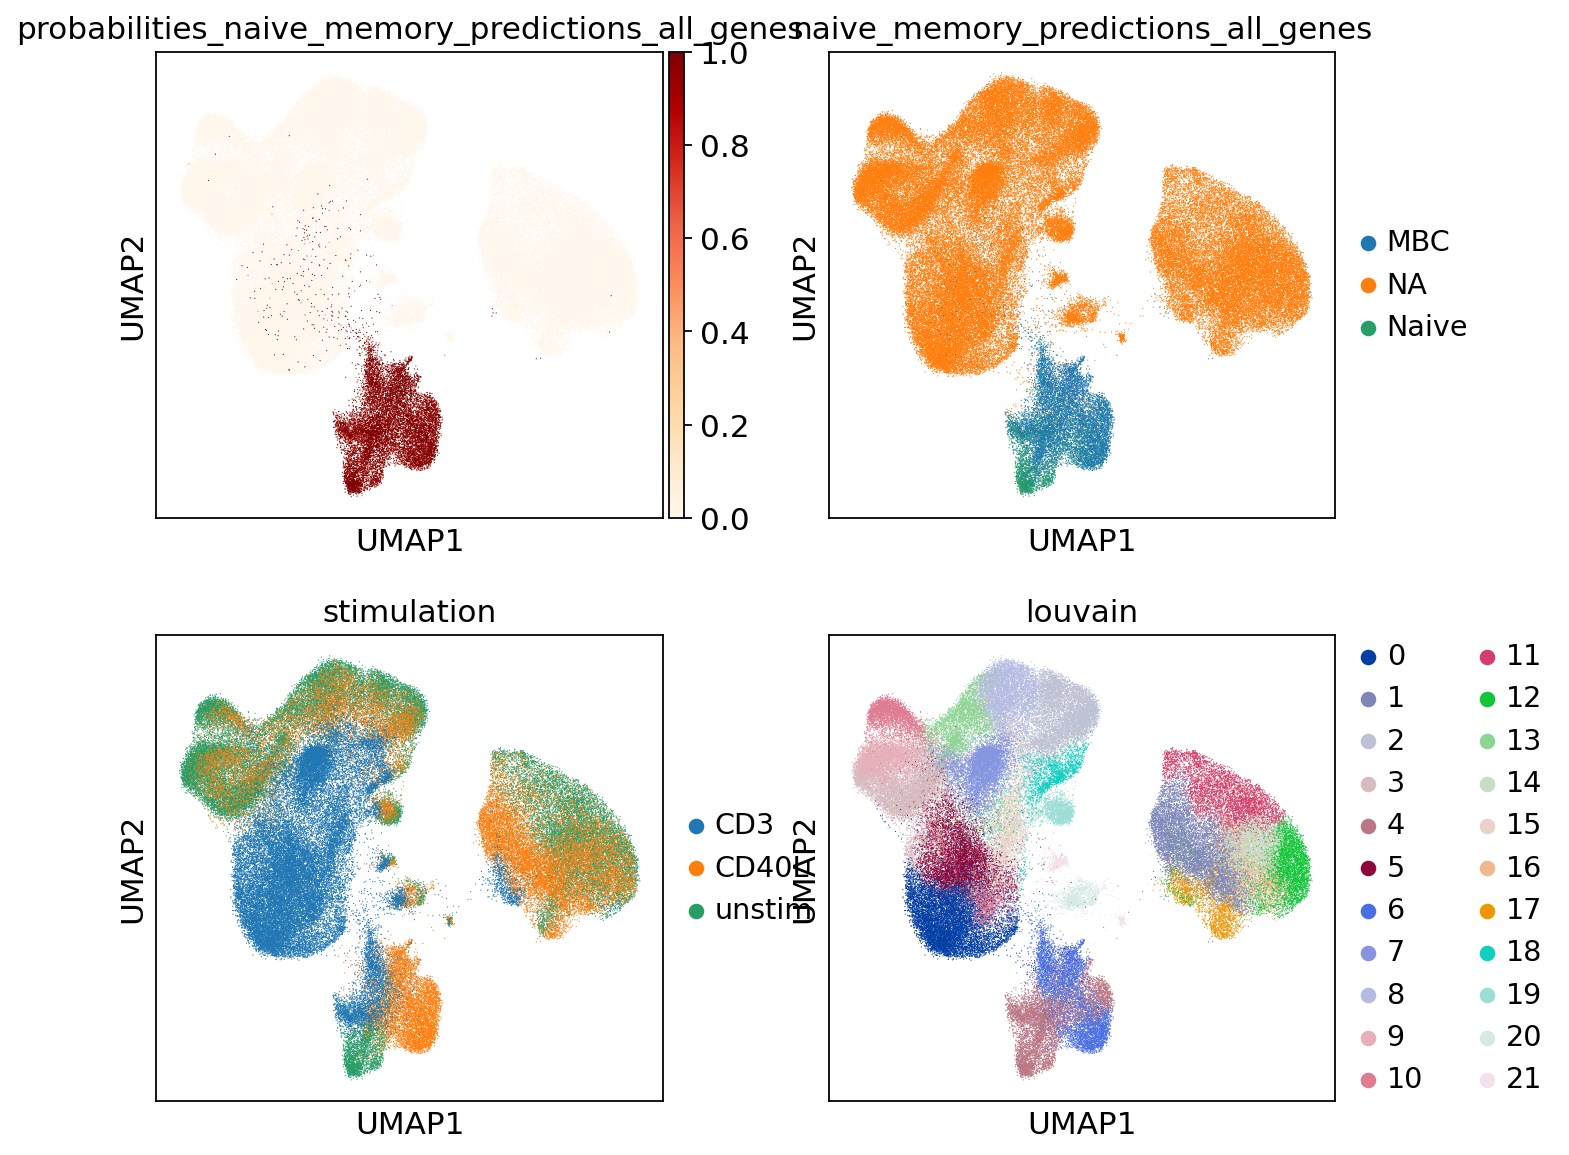

In [126]:
sc.pl.umap(adata_hvg, color = [#'probabilities_GC_hvgs', 'GC_celltype_predictions_hvgs',
                               'probabilities_naive_memory_predictions_all_genes', 'naive_memory_predictions_all_genes',
                              'stimulation', 'louvain'],
           ncols=2,
           cmap='OrRd')

In [127]:
table_predictions = adata_hvg.obs.loc[:, ['naive_memory_predictions_all_genes', 'probabilities_naive_memory_predictions_all_genes']]

In [128]:
table_predictions.head()

naive_memory_predictions_all_genes  \
index                                                   
AAACCTGAGAATGTGT-1                                 NA   
AAACCTGAGACTAAGT-1                                 NA   
AAACCTGAGCCGCCTA-1                                 NA   
AAACCTGAGCGCCTCA-1                                 NA   
AAACCTGAGGATGTAT-1                                 NA   

                    probabilities_naive_memory_predictions_all_genes  
index                                                                 
AAACCTGAGAATGTGT-1                                               0.0  
AAACCTGAGACTAAGT-1                                               0.0  
AAACCTGAGCCGCCTA-1                                               0.0  
AAACCTGAGCGCCTCA-1                                               0.0  
AAACCTGAGGATGTAT-1                                               0.0

In [129]:
table_predictions.shape

(107050, 2)

In [130]:
table_predictions.to_csv(save_path + 'table_predictions_naive_memory_B_cells_from_Hamish_B_cells_GEX_and_SoupX_denoised_protein_validation_cohort_20210215.csv')

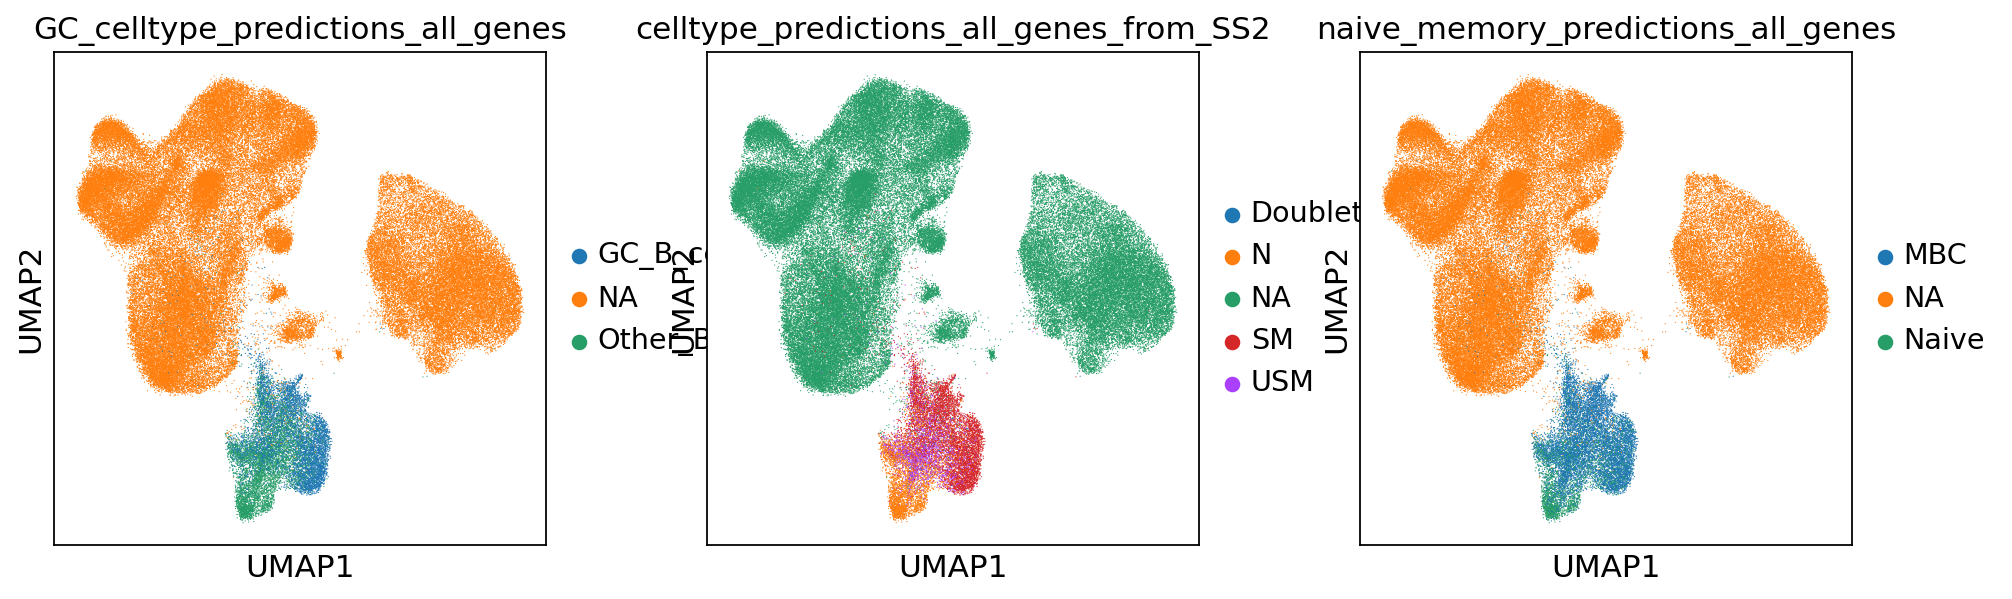

In [131]:
sc.pl.umap(adata_hvg, color=['GC_celltype_predictions_all_genes',
                             'celltype_predictions_all_genes_from_SS2',
                             'naive_memory_predictions_all_genes'])

In [148]:
# how are these predictions distributed across activations?
adata_hvg_B_cells = adata_hvg[adata_hvg.obs['cell_type_final'].isin(['B_cells_memory', 'B_cells_naive', 'Plasma_cells'])].copy()

In [149]:
df_stats = pd.DataFrame(columns=list(np.unique(adata_hvg_B_cells.obs['naive_memory_predictions_all_genes'])),
                     index=list(np.unique(adata_hvg_B_cells.obs['stimulation'])))

In [150]:
df_stats

MBC Naive
BCR     NaN   NaN
CD3     NaN   NaN
CD40L   NaN   NaN
unstim  NaN   NaN

In [151]:
for prediction in df_stats.columns:
    print('prediction', prediction)
    for stimulation in df_stats.index:
        #print(sample)
        df_stats.loc[stimulation, prediction] = adata_hvg[(adata_hvg.obs['stimulation'] == stimulation)
                                         & (adata_hvg.obs['naive_memory_predictions_all_genes'] == prediction)].X.shape[0]

prediction MBC
prediction Naive


In [152]:
df_stats

MBC  Naive
BCR     2031   1233
CD3     2471    514
CD40L   4844    689
unstim  1580   1500

In [125]:
#cols_new_order = [str(i) for i in range(1,22)]
#df_new = df_new[cols_new_order]
#df_new

Text(0.5, 0, 'stimulation')

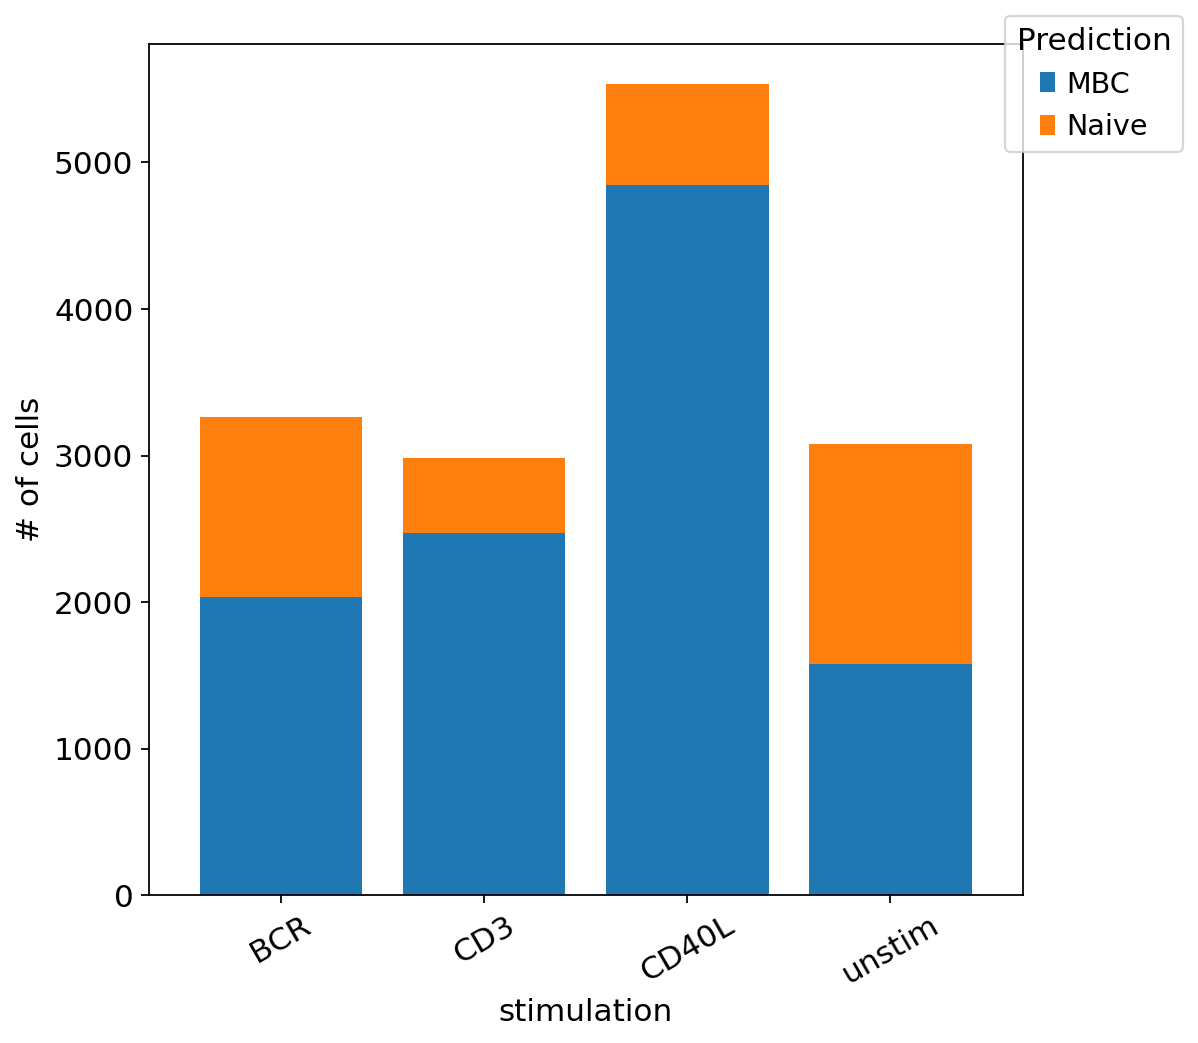

In [153]:
# this is for final cells only

ax = df_stats.plot.bar(stacked=True, figsize=(7,7), width=0.8)

handles, labels = ax.get_legend_handles_labels()

ax.legend(handles,
          labels, title='Prediction',
          bbox_to_anchor=(1.20, 1.05))

ax.set_xticklabels(labels=['BCR',
                           'CD3',
                           'CD40L',
                           'unstim'])
ax.tick_params(axis='x', rotation=30)

# to turn off the grid
plt.grid(b=None)

#plt.title('CITE-seq sample composition')
plt.ylabel('# of cells')
plt.xlabel('stimulation')

#plt.savefig('./figures/CITE-seq_sample_composition_all_samples_final_cells_20210112.pdf',
#           bbox_inches='tight')

# 3. Not doing this anymore: predicting Naive/Memory B cells from (b) [covid dataset](https://www.covid19cellatlas.org/index.patient.html) (Immunodeficiency PBMCs)

In [9]:
# id for immunodeficiency
adata_covid_id = sc.read('./immunodeficiency_PMBCs.h5ad')

In [10]:
adata_covid_id

AnnData object with n_obs × n_vars = 240627 × 33759
    obs: 'PreCondition', 'Hospitalized', 'Disease_classification', 'Deconvolved_samples', 'MT_fraction', 'log1p_total_counts', 'log2p1_nCiteseq_count', 'n_genes_by_counts', 'nCiteseq_features', 'CellType', 'Lab number', 'Donor Id', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing Hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', 'Cell sorting'
    var: 'gene_ids', 'feature_types', 'RBC_0', 'RBC_1', 'RBC_2', 'RBC_3', 'RBC_4', 'RBC_5', 'RBC_6', 'RBC_7', 'RBC_8', 'RBC_filtered'
    uns: '28-day death_colors', 'Admitted to hospital_colors', 'BLD_scmap_colors', 'CellType_colors', 'Pre-existing diabetes_colors', 'Pre-exis

In [11]:
# here the values are log2(raw_count + 1), using these
adata_covid_id.X

<240627x33759 sparse matrix of type '<class 'numpy.float64'>'
	with 458138140 stored elements in Compressed Sparse Column format>

In [13]:
np.unique(adata_covid_id.obs['CellType'])

array(['Activated monocytes', 'Bcells memory', 'Bcells naive',
       'Classical monocytes', 'Cycling Lymphocytes', 'Erythrocytes',
       'Gamma-delta', 'IFN Lymphocytes', 'Intermediate monocytes',
       'Low qc', 'Low qc monocytes', 'NK cytokine secretion',
       'NK cytolitic', 'Non-classical monocytes', 'Plasma Bcells',
       'Platets', 'Progenitors', 'Tcells CD4', 'Tcells CD8',
       'Tcells CD8 IL10', 'Tcells memory CD4', 'Tcells memory CD8',
       'Tcells naive', 'Treg', 'cDC1', 'cDC2', 'cell doublet',
       'filtered cells', 'pDC'], dtype=object)

In [14]:
# subsetting to only B cell clusters
adata_covid_id = adata_covid_id[adata_covid_id.obs['CellType'].isin(['Bcells memory', 'Bcells naive'])]

In [15]:
# scaling
sc.pp.scale(adata_covid_id, max_value=10)

/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [16]:
adata_hvg_B_cells = adata_hvg[adata_hvg.obs['cell_type_final'].isin(['B_cells_memory', 'B_cells_naive', 'Plasma_cells'])].copy()

In [17]:
adata_B_full = anndata.AnnData(X = adata_hvg_B_cells.raw.X,
                              obs = adata_hvg_B_cells.obs,
                              var = adata_hvg_B_cells.raw.var,
                              obsm = adata_hvg_B_cells.obsm,
                              varm = adata_hvg_B_cells.raw.varm)

# scaling
sc.pp.scale(adata_B_full, max_value=10)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [18]:
# full (all genes) versions of the annotated object and test object
# here both the datasets are normalised, log transformed and scaled
adata_train = adata_covid_id.copy()

adata_test = adata_B_full.copy()

In [19]:
adata_test

AnnData object with n_obs × n_vars = 14862 × 22144
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_ids-4', 'f

In [20]:
adata_train

AnnData object with n_obs × n_vars = 6927 × 33759
    obs: 'PreCondition', 'Hospitalized', 'Disease_classification', 'Deconvolved_samples', 'MT_fraction', 'log1p_total_counts', 'log2p1_nCiteseq_count', 'n_genes_by_counts', 'nCiteseq_features', 'CellType', 'Lab number', 'Donor Id', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing Hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', 'Cell sorting'
    var: 'gene_ids', 'feature_types', 'RBC_0', 'RBC_1', 'RBC_2', 'RBC_3', 'RBC_4', 'RBC_5', 'RBC_6', 'RBC_7', 'RBC_8', 'RBC_filtered', 'mean', 'std'
    uns: '28-day death_colors', 'Admitted to hospital_colors', 'BLD_scmap_colors', 'CellType_colors', 'Pre-existing diabetes_color

### Subsetting both datasets' copies to common genes only

I will train logreg on the subsetted data and tranfer the annotation onto the corresponding subsetted new data and then transfer that onto the full (with all genes) new dataset

In [21]:
# list of genes shared between blood and bone marrow data
# doing sorted on the overall list is VERY important for consistent ordering of the genes
common_genes = sorted(list(set(adata_train.var_names) & set(adata_test.var_names)))
print(len(common_genes),"genes are shared between previous training and test data \n",
      len(set(adata_train.var_names)), 'genes in training data \n',
      len((set(adata_test.var_names))), 'genes in test joint data \n')

17062 genes are shared between previous training and test data 
 33759 genes in training data 
 22144 genes in test joint data 



In [22]:
adata_train.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
       ...
       'ab_CD101(BB27)', 'ab_CD360(IL-21R)', 'ab_CD88(C5aR)', 'ab_HLA-F',
       'ab_NLRP2', 'ab_Podocalyxin', 'ab_CD224', 'ab_anti-c-Met',
       'ab_CD258(LIGHT)', 'ab_DR3(TRAMP)'],
      dtype='object', length=33759)

Going to copy a joint dataset with only common genes, but then transfer annotation from logreg onto the full dataset

In [23]:
adata_train_copy = adata_train[:,common_genes]

In [24]:
adata_train_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2ML1', 'A4GALT', 'A4GNT',
       'AAAS', 'AACS', 'AADAT',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', length=17062)

In [25]:
adata_test_copy = adata_test[:,common_genes]
adata_test_copy.var_names

Index(['A1BG', 'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2ML1', 'A4GALT', 'A4GNT',
       'AAAS', 'AACS', 'AADAT',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', length=17062)

In [26]:
# checking gene correspondence!
list(adata_test_copy.var_names) == list(adata_train_copy.var_names)

True

In [27]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 6927 × 17062
    obs: 'PreCondition', 'Hospitalized', 'Disease_classification', 'Deconvolved_samples', 'MT_fraction', 'log1p_total_counts', 'log2p1_nCiteseq_count', 'n_genes_by_counts', 'nCiteseq_features', 'CellType', 'Lab number', 'Donor Id', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing Hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', 'Cell sorting'
    var: 'gene_ids', 'feature_types', 'RBC_0', 'RBC_1', 'RBC_2', 'RBC_3', 'RBC_4', 'RBC_5', 'RBC_6', 'RBC_7', 'RBC_8', 'RBC_filtered', 'mean', 'std'
    uns: '28-day death_colors', 'Admitted to hospital_colors', 'BLD_scmap_colors', 'CellType_colors', 'Pre-existing diabet

In [28]:
np.unique(adata_train_copy.obs['CellType'],return_counts=True)

(array(['Bcells memory', 'Bcells naive'], dtype=object), array([1574, 5353]))

# Training a logistic regression model on previously annotated SS2 data

In [29]:
adata_train_copy.obs['CellType'].head()

I-O-1_13_T_AAACGGGAGGTAGCCA-1-0    Bcells memory
I-O-1_13_T_AAAGATGTCAGGCGAA-1-0     Bcells naive
I-O-1_13_T_AAAGCAACAGACAGGT-1-0     Bcells naive
I-O-1_13_T_AAAGCAATCTCTGTCG-1-0     Bcells naive
I-O-1_13_T_AACCATGAGTCGTTTG-1-0    Bcells memory
Name: CellType, dtype: category
Categories (2, object): [Bcells naive < Bcells memory]

In [30]:
celltypes_train = adata_train_copy.obs['CellType']

In [31]:
adata_train_copy.X.shape

(6927, 17062)

Using ONLY COMMON GENES

In [32]:
%%time
# training a logistic regression model
logisticRegr = LogisticRegression(max_iter = 10000, n_jobs = -1, random_state = 0, C=0.2)
logisticRegr.fit(adata_train_copy.X, celltypes_train)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 16.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


CPU times: user 1min 22s, sys: 2min 5s, total: 3min 28s
Wall time: 45.6 s


LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [33]:
# already done
# Saving model based on all genes
pkl_filename = "logreg_from_covid_all_genes_20210113.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(logisticRegr, file)

In [34]:
adata_train_copy

View of AnnData object with n_obs × n_vars = 6927 × 17062
    obs: 'PreCondition', 'Hospitalized', 'Disease_classification', 'Deconvolved_samples', 'MT_fraction', 'log1p_total_counts', 'log2p1_nCiteseq_count', 'n_genes_by_counts', 'nCiteseq_features', 'CellType', 'Lab number', 'Donor Id', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing Hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', 'Cell sorting'
    var: 'gene_ids', 'feature_types', 'RBC_0', 'RBC_1', 'RBC_2', 'RBC_3', 'RBC_4', 'RBC_5', 'RBC_6', 'RBC_7', 'RBC_8', 'RBC_filtered', 'mean', 'std'
    uns: '28-day death_colors', 'Admitted to hospital_colors', 'BLD_scmap_colors', 'CellType_colors', 'Pre-existing diabet

In [35]:
adata_test_copy

View of AnnData object with n_obs × n_vars = 14862 × 17062
    obs: 'n_genes', 'stimulation', 'sample', 'cell_id', 'percent_mito', 'n_counts', 'dataset', 'technique', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'batch', 'is_doublet', 'cell_type_final', 'S_score', 'G2M_score', 'phase', 'louvain', 'n_counts_protein', 'n_counts_protein_lognorm', 'donor', 'Age', 'Sex', 'Age of disease onset', 'Autoimmunity', 'Gastrointestinal disease', 'Lung disease (bronchiectasis)', 'Lymphoadenopathy ', 'Splenomegaly', 'History of hypogammaglobulinemia, IgA deficiency or immunodeficiency in other family members', 'CVID_status'
    var: 'gene_ids-0', 'feature_types-0', 'genome-0', 'n_cells-0', 'gene_ids-1', 'feature_types-1', 'genome-1', 'n_cells-1', 'gene_ids-10', 'feature_types-10', 'genome-10', 'n_cells-10', 'gene_ids-11', 'feature_types-11', 'genome-11', 'n_cells-11', 'gene_ids-2', 'feature_types-2', 'genome-2', 'n_cells-2', 'gene_ids-3', 'feature_types-3', 'genome-3', 'n_cells-3', 'gene_id

In [36]:
logisticRegr

LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=0,
                   solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [37]:
%%time
predictions = logisticRegr.predict(adata_test_copy.X)
adata_test_copy.obs['celltype_predictions_all_genes_from_covid'] = predictions

Trying to set attribute `.obs` of view, copying.


CPU times: user 12.7 s, sys: 4.56 s, total: 17.3 s
Wall time: 15.6 s


In [38]:
%%time
# probabilities
probabilities = logisticRegr.predict_proba(adata_test_copy.X)
probs_adata = []
for i,clus in enumerate(adata_test_copy.obs['celltype_predictions_all_genes_from_covid']):
    probs_adata.append(probabilities[i,logisticRegr.classes_==clus][0])


CPU times: user 1.3 s, sys: 1.46 s, total: 2.76 s
Wall time: 877 ms


In [39]:
# need to only assign predictions and probabilities to B cell clusters
list(adata_test_copy.obs.index) == list(adata_hvg.obs.index)

False

In [40]:
adata_test_copy.obs['probabilities_from_covid_all_genes'] = probs_adata

In [41]:
def add_predictions_and_probs(barcode, 
                              col # either celltype_predictions_all_genes_from_SS2 or probabilities_from_SS2_all_genes
                             ):
    
    barcode_is_B_cell = barcode in adata_test_copy.obs_names
    
    if barcode_is_B_cell:
        value = adata_test_copy.obs.loc[barcode, col]
        return(value)
    else:
        if col == 'probabilities_from_covid_all_genes':
            return(0)
        elif col == 'celltype_predictions_all_genes_from_covid':
            return('NA')
        

In [42]:
adata_hvg.obs['barcode'] = adata_hvg.obs.index

In [43]:
for column in ['celltype_predictions_all_genes_from_covid','probabilities_from_covid_all_genes']:
    print(column)
    adata_hvg.obs[column] = adata_hvg.obs['barcode'].apply(lambda x: add_predictions_and_probs(x, column))

celltype_predictions_all_genes_from_covid
probabilities_from_covid_all_genes


... storing 'cell_type_final' as categorical
... storing 'celltype_predictions_all_genes_from_covid' as categorical


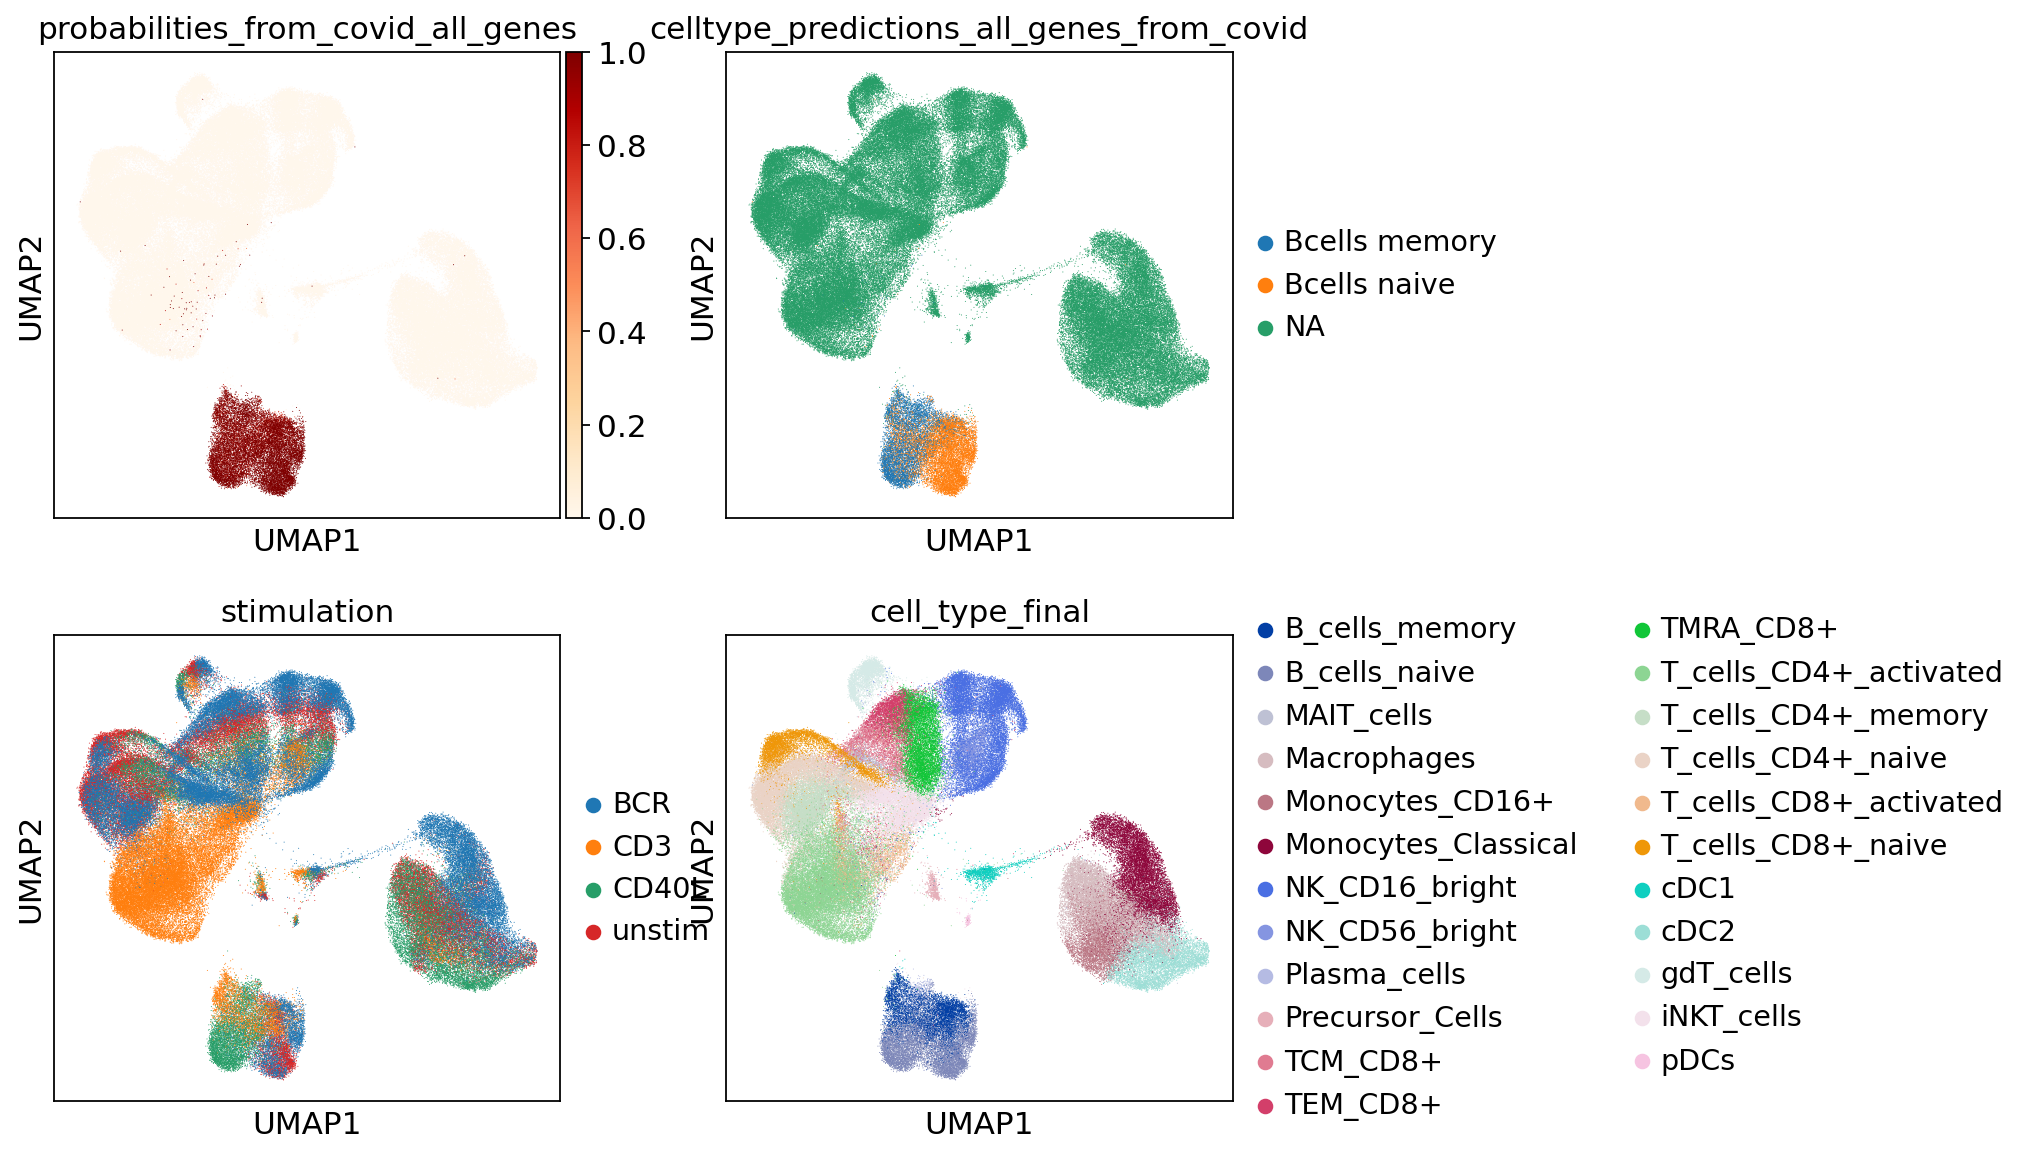

In [44]:
sc.pl.umap(adata_hvg, color = [#'probabilities_GC_hvgs', 'GC_celltype_predictions_hvgs',
                               'probabilities_from_covid_all_genes', 'celltype_predictions_all_genes_from_covid',
                              'stimulation', 'cell_type_final'],
           ncols=2,
           cmap='OrRd')

### this makes sense because in the covid dataset there were only non-activated B cells, so here it predicts B memory lables in the activated B cell compartment, although correctly predicts the B cells in unstim + BCR compartment

In [45]:
table_predictions_from_covid = adata_hvg.obs.loc[:, ['celltype_predictions_all_genes_from_covid', 'probabilities_from_covid_all_genes']]

In [46]:
table_predictions_from_covid.head()

celltype_predictions_all_genes_from_covid  \
AAACCTGAGAATGTGT-1                                        NA   
AAACCTGAGACTAAGT-1                                        NA   
AAACCTGAGCCGCCTA-1                                        NA   
AAACCTGAGCGCCTCA-1                                        NA   
AAACCTGAGGATGTAT-1                                        NA   

                    probabilities_from_covid_all_genes  
AAACCTGAGAATGTGT-1                                 0.0  
AAACCTGAGACTAAGT-1                                 0.0  
AAACCTGAGCCGCCTA-1                                 0.0  
AAACCTGAGCGCCTCA-1                                 0.0  
AAACCTGAGGATGTAT-1                                 0.0

In [47]:
table_predictions_from_covid.shape

(145823, 2)

In [48]:
table_predictions_from_covid.to_csv(save_path + 'table_predictions_naive_memory_B_cells_from_covid_GEX_and_SoupX_denoised_protein_all_samples_20210113.csv')